# Introduction

This notebook embarks on an analysis of two distinct datasets, both sourced from experimental data. The initial dataset pertains to a Single Zone Constant Air Volume (SZCAV) Air Handling Unit (AHU), while the second dataset concerns a Single Zone Variable Air Volume (SZVAV) AHU.

Following data was used in the dataset:

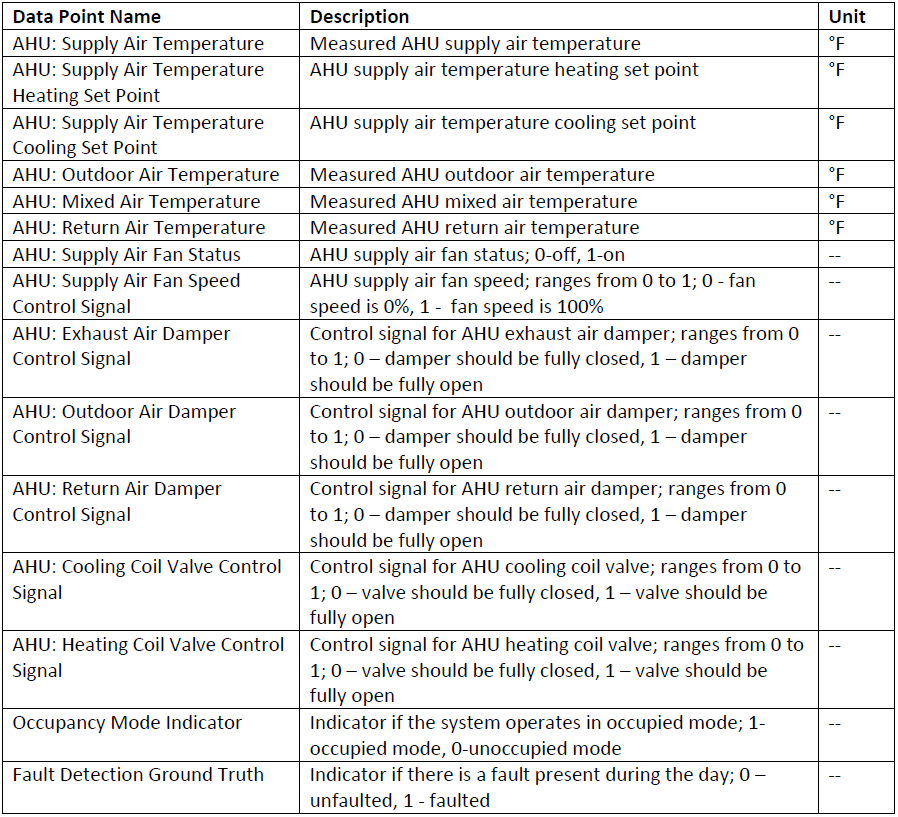

The faults within the dataset were introduced through experimental interventions. Each individual fault was intentionally imposed on the unit at midnight and persisted for the duration of an entire day. 

Fault imposed in single-zone constant air volume AHU are as follow:

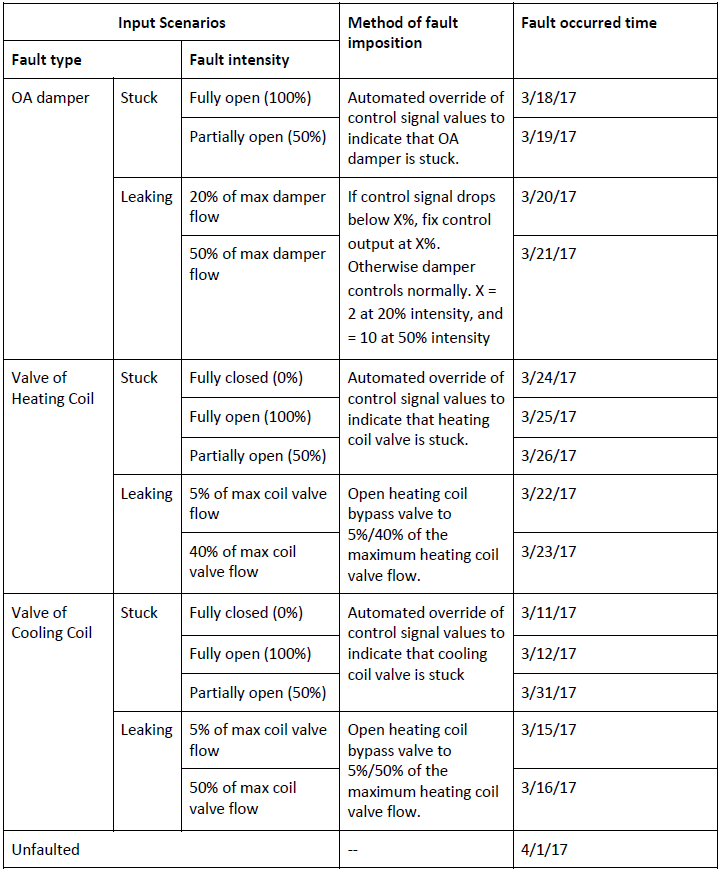

Fault imposed in single-zone variable air volume AHU are as follow:

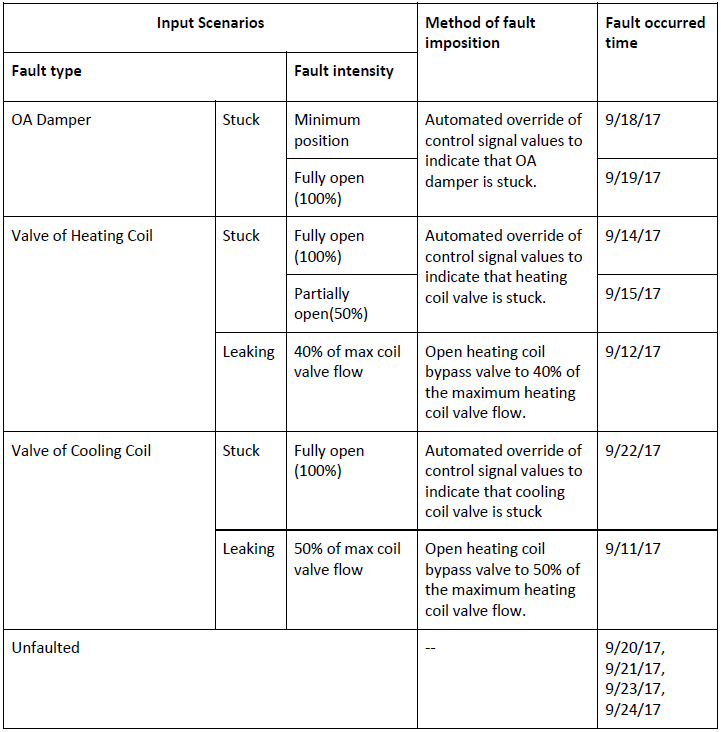

# Import of the relevant libraries and notebook preparation

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
from scripts import convert_date, train_evaluate_classification_models, train_evaluate_regression_models

In [62]:
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [63]:
warnings.filterwarnings("ignore")

In [64]:
# preparing list of classifiacation algorithms for comparison and to choose the best one
classifiers = [['KNeighborsClassifier', KNeighborsClassifier()],
              ['MLPClassifier',MLPClassifier()],
              ['AdaBoostClassifier',AdaBoostClassifier()],
              ['GradientBoostingClassifier',GradientBoostingClassifier()],
              ['CatBoostClassifier', CatBoostClassifier()],
              ['XGBClassifier', XGBClassifier()],
              ['BaggingClassifier', BaggingClassifier()],
              ['RandomForestClassifier', RandomForestClassifier()],
              ['DecisionTreeClassifier', DecisionTreeClassifier()],
              ['LogisticRegression', LogisticRegression()]]

In [65]:
raw_data_vav = pd.read_csv('SZVAV.csv')

In [66]:
raw_data_cav = pd.read_csv('SZCAV.csv')

# Single-zone constant air volume AHU

## Data exploration and feature engineering

In [67]:
raw_data_cav.sample(5)

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
12645,3/22/2017 18:45,74.77,50.00,86.00,48.77,72.25,72.77,1,0.5,0.000000,1.0,0.0,0.000000,0.000000,0,1
4635,3/16/2017 5:15,64.12,64.06,86.00,53.13,64.37,64.75,1,0.5,0.000000,1.0,0.0,0.000000,0.362752,0,1
21140,4/1/2017 16:20,66.75,50.00,66.89,66.62,64.88,69.63,1,0.5,1.000000,0.0,0.5,0.112374,0.000000,1,0
11248,3/21/2017 19:28,66.20,50.00,86.00,54.88,64.82,67.71,1,0.5,0.000000,1.0,0.0,0.000000,0.000000,0,1
14187,3/23/2017 20:27,86.33,50.00,86.00,49.99,75.47,81.70,1,0.5,0.163128,1.0,0.0,0.000000,0.000000,0,1


In [68]:
raw_data_cav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 0 to 21599
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Datetime                                       21600 non-null  object 
 1   AHU: Supply Air Temperature                    21600 non-null  float64
 2   AHU: Supply Air Temperature Heating Set Point  21600 non-null  float64
 3   AHU: Supply Air Temperature Cooling Set Point  21600 non-null  float64
 4   AHU: Outdoor Air Temperature                   21600 non-null  float64
 5   AHU: Mixed Air Temperature                     21600 non-null  object 
 6   AHU: Return Air Temperature                    21600 non-null  float64
 7   AHU: Supply Air Fan Status                     21600 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal       21600 non-null  float64
 9   AHU: Outdoor Air Damper Control Signal         216

The dataset exhibits the absence of any null values, demonstrating its initial data integrity. However, adjustments are required in two columns: "AHU: Mixed Air Temperature" and "Datetime." Specifically, changes in datatype are necessary for these columns to ensure uniformity and proper handling of the data.

In [69]:
raw_data_cav['Datetime'] = pd.to_datetime(raw_data_cav['Datetime'])

In [70]:
# Changing column values to numeric values, changing all defective data to NaN
raw_data_cav['AHU: Mixed Air Temperature'] = pd.to_numeric(raw_data_cav['AHU: Mixed Air Temperature'],errors='coerce')

In [71]:
raw_data_cav['AHU: Mixed Air Temperature'].isna().sum()

90

It is observed that there are 90 rows within the "AHU: Mixed Air Temperature" column containing defective data. Given the dataset's scale, this represents a relatively minor fraction. Consequently, it is a reasonable approach to remove these rows, ensuring the overall dataset's integrity and consistency.

In [72]:
raw_data_cav.dropna(inplace=True)

In [73]:
raw_data_cav.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21510 entries, 0 to 21599
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   Datetime                                       21510 non-null  datetime64[ns]
 1   AHU: Supply Air Temperature                    21510 non-null  float64       
 2   AHU: Supply Air Temperature Heating Set Point  21510 non-null  float64       
 3   AHU: Supply Air Temperature Cooling Set Point  21510 non-null  float64       
 4   AHU: Outdoor Air Temperature                   21510 non-null  float64       
 5   AHU: Mixed Air Temperature                     21510 non-null  float64       
 6   AHU: Return Air Temperature                    21510 non-null  float64       
 7   AHU: Supply Air Fan Status                     21510 non-null  int64         
 8   AHU: Supply Air Fan Speed Control Signal       21510 non

In [74]:
raw_data_cav.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
count,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000
mean,68.584346,56.308631,80.418358,54.732109,65.155592,69.822446,0.999303,0.499675,0.250513,0.834856,0.082572,0.128883,0.139289,0.502092,0.933752
std,7.798999,9.889737,11.928306,5.366600,5.752576,5.199783,0.026399,0.012752,0.363272,0.365543,0.182772,0.326036,0.247166,0.500007,0.248721
min,49.210000,50.000000,50.000000,44.600000,46.280000,58.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.860000,50.000000,86.000000,50.590000,62.650000,66.180000,1.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,67.540000,50.000000,86.000000,53.700000,65.260000,69.150000,1.000000,0.500000,0.150000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,72.540000,61.850000,86.000000,57.610000,68.000000,72.330000,1.000000,0.500000,0.150000,1.000000,0.000000,0.000000,0.279320,1.000000,1.000000
max,88.830000,86.000000,86.000000,71.180000,80.870000,83.230000,1.000000,0.500000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000


The data cleaning process appears to be successfully completed. With a clean dataset in hand, the next step is to proceed with selecting the data necassary for the purpose of model construction. This involves identifying and retaining the features that hold the most significance for the desired modeling objectives.

In [75]:
data_cav = raw_data_cav.copy()

<AxesSubplot:>

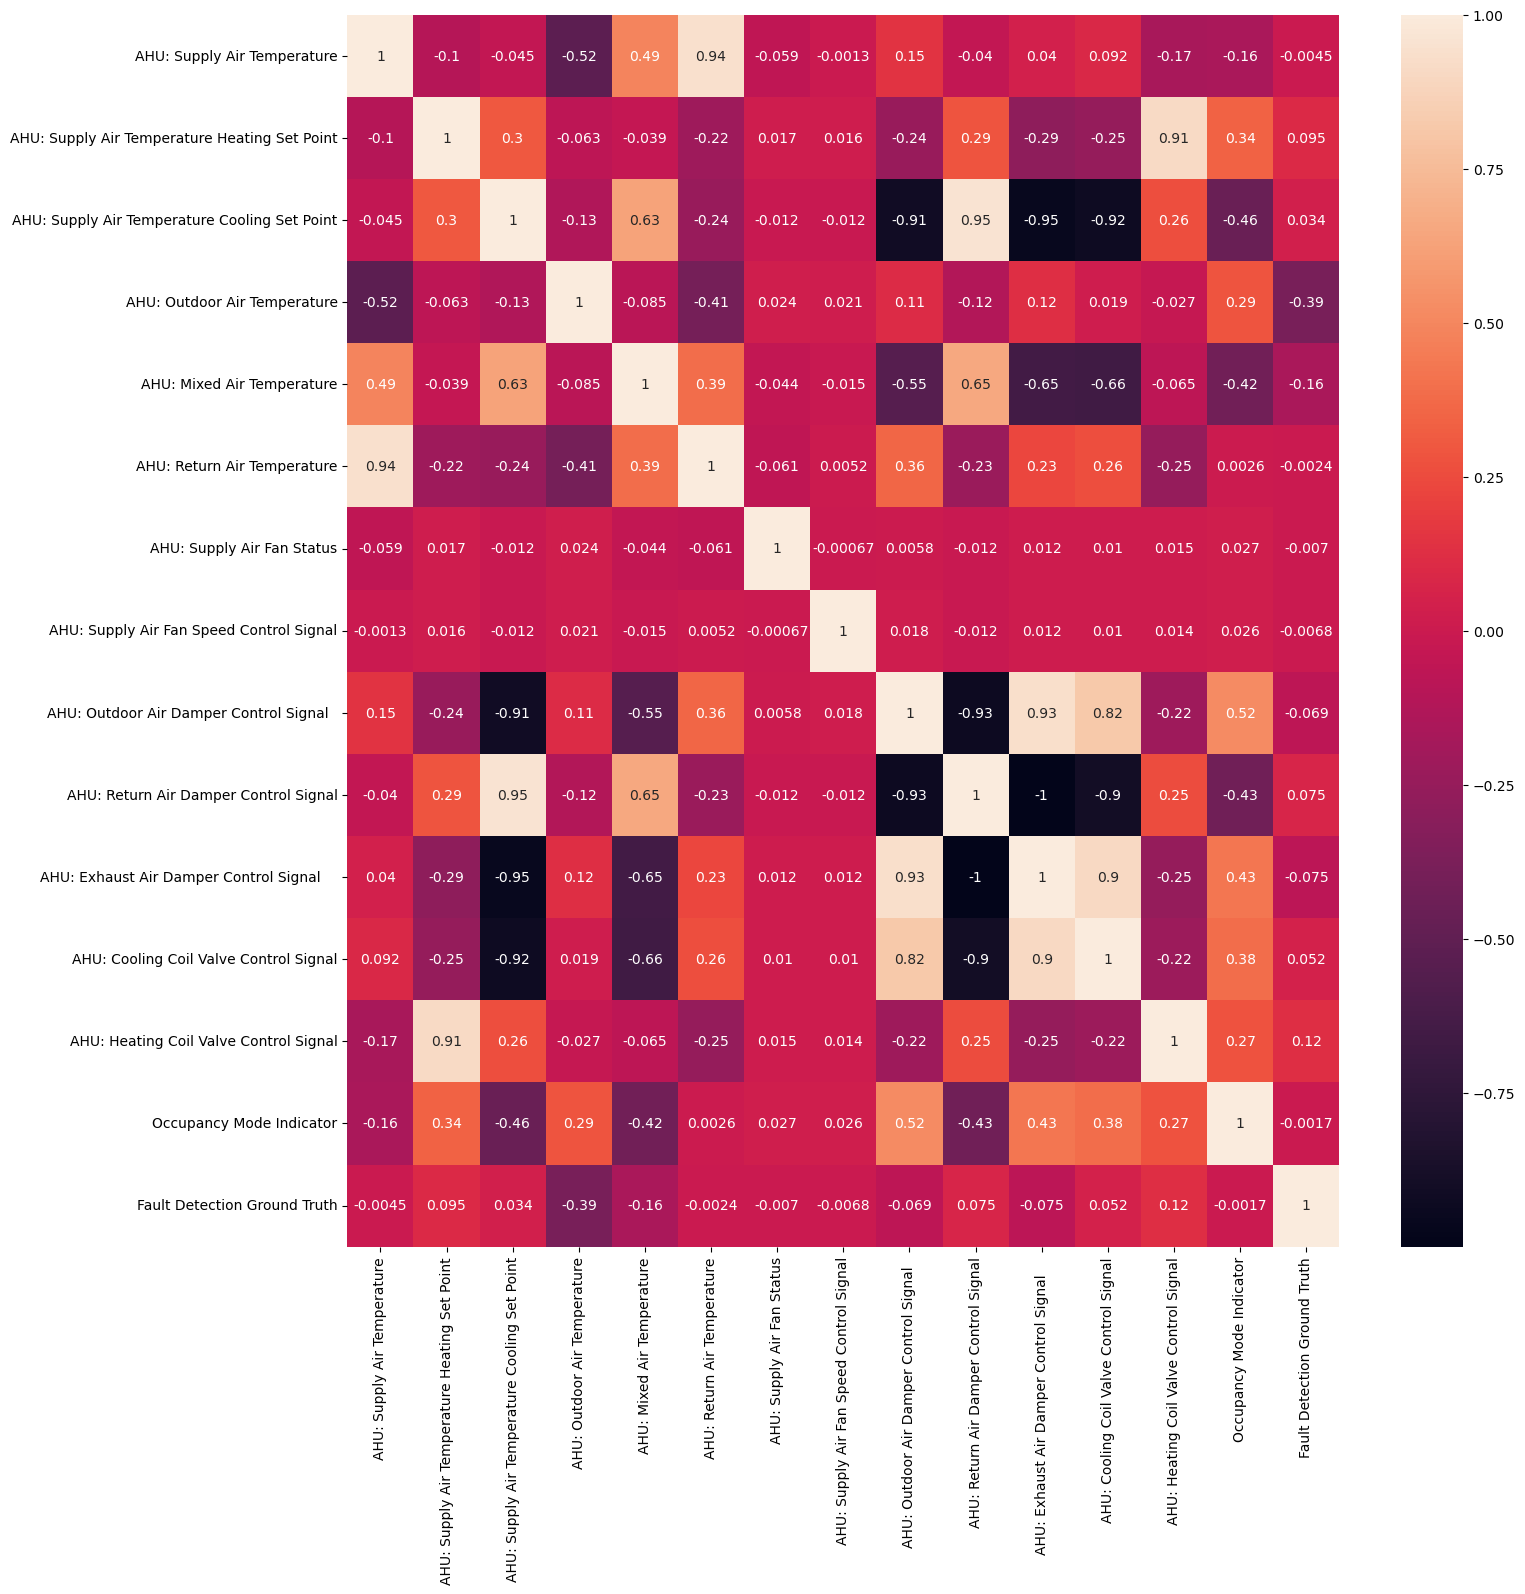

In [76]:
plt.figure(figsize=(16,16))
sns.heatmap(data_cav.corr(), annot=True)

The data analysis reveals notable correlations among the columns "AHU: Outdoor Air Damper Control Signal," "AHU: Return Air Damper Control Signal," and "AHU: Exhaust Air Damper Control Signal." To mitigate redundancy, only one of these columns will be retained.

However, the columns "AHU: Supply Air Temperature Cooling Set Point" and "AHU: Cooling Coil Valve Control Signal," despite exhibiting correlations with the columns mentioned earlier, exhibit distinct characteristics and employ different value units. As a result, these columns will be preserved for analysis, as their relevance differs from the correlated set of damper control signal columns.

In [77]:
data_cav.drop(['AHU: Return Air Damper Control Signal', 'AHU: Exhaust Air Damper Control Signal    '], axis=1, inplace=True)

<AxesSubplot:>

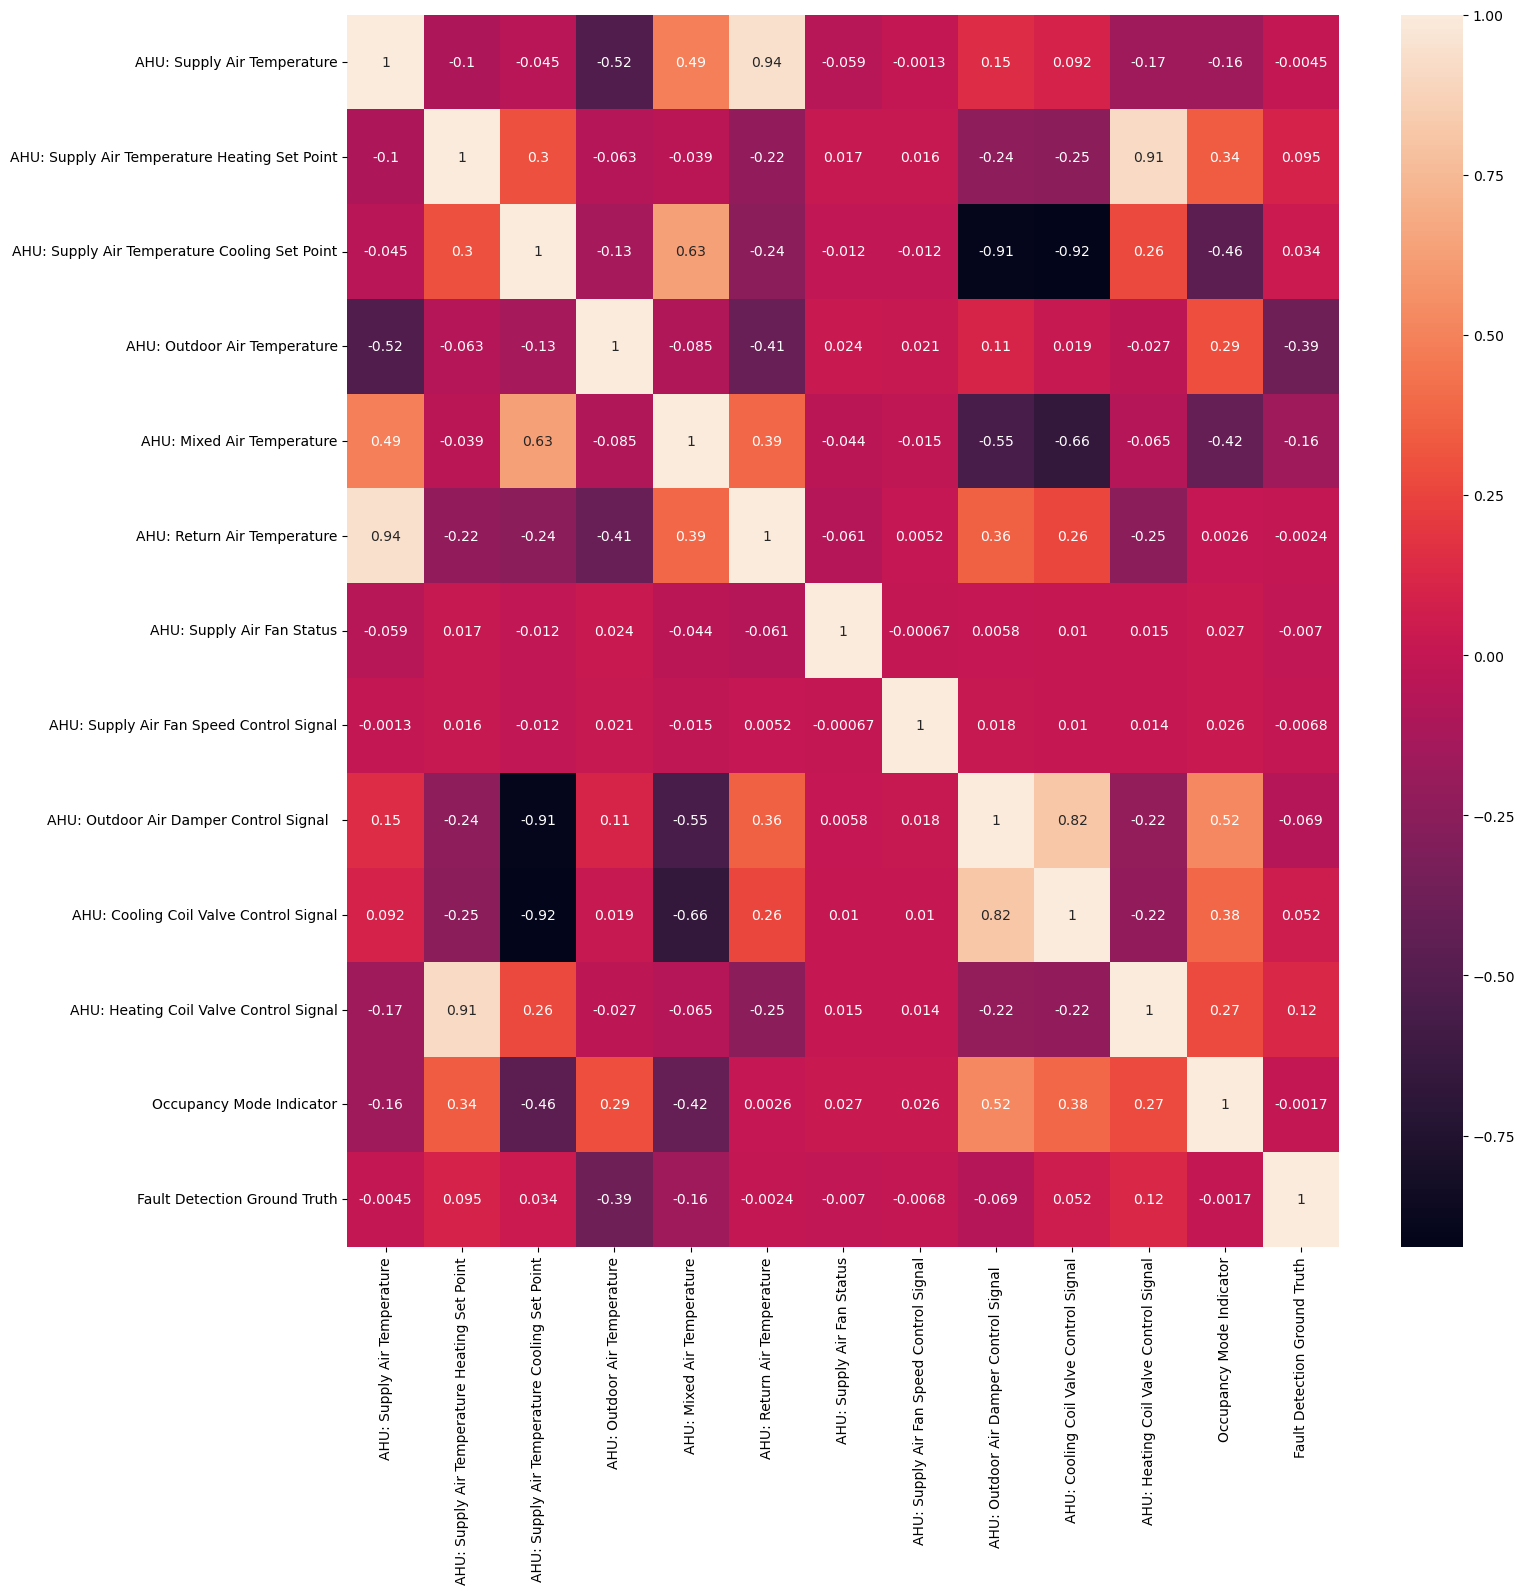

In [78]:
plt.figure(figsize=(16,16))
sns.heatmap(data_cav.corr(), annot=True)

The feature data seems ready for model construction. Regarding the "Fault Detection Ground Truth" column, its content contains a wide spectrum of distinct faults. Consequently, analogous to the other datasets, it is recommended to create separate target columns for each specific type of fault. This approach ensures that the models can effectively discern and predict the diverse fault categories present within the dataset.

In [79]:
# Creating list of dates when faults occured accordin to the description.
OA_fault_dates = [convert_date('9/18/17'), 
                  convert_date('9/19/17')]
heat_vlv_fault_dates = [convert_date('9/14/17'), 
                        convert_date('9/15/17'), 
                        convert_date('9/12/17')]
cool_vlv_fault_dates = [convert_date('9/22/17'), 
                        convert_date('9/11/17')]
OA_fault_dates = [convert_date('3/18/17'), 
                  convert_date('3/19/17'), 
                  convert_date('3/20/17'), 
                  convert_date('3/21/17')]
heat_vlv_fault_dates = [convert_date('3/24/17'), 
                        convert_date('3/25/17'), 
                        convert_date('3/26/17'),
                        convert_date('3/22/17'),
                        convert_date('3/23/17')]
cool_vlv_fault_dates = [convert_date('3/11/17'), 
                        convert_date('3/12/17'), 
                        convert_date('3/31/17'),
                        convert_date('3/15/17'),
                        convert_date('3/16/17')]

In [80]:
# Creating and filling faults column with values according to the dates given earlier.
data_cav['OA_fault'] = 0
data_cav['heat_vlv_fault'] = 0
data_cav['cool_vlv_fault'] = 0
for date in OA_fault_dates:
    data_cav.loc[data_cav['Datetime'].dt.date == date.date(), 'OA_fault'] = 1
for date in heat_vlv_fault_dates:
    data_cav.loc[data_cav['Datetime'].dt.date == date.date(), 'heat_vlv_fault'] = 1
for date in cool_vlv_fault_dates:
    data_cav.loc[data_cav['Datetime'].dt.date == date.date(), 'cool_vlv_fault'] = 1

## Models building

### Feature and target data preparation

In [81]:
X = data_cav.drop(['Datetime','Fault Detection Ground Truth', 'OA_fault','heat_vlv_fault','cool_vlv_fault'], axis=1)

In [82]:
y_oa = data_cav['OA_fault']
y_heat = data_cav['heat_vlv_fault']
y_cool = data_cav['cool_vlv_fault']

In [83]:
X_train_oa_cav, X_test_oa_cav, y_train_oa_cav, y_test_oa_cav = train_test_split(X, y_oa, test_size=0.1, shuffle=True)
X_train_heat_cav, X_test_heat_cav, y_train_heat_cav, y_test_heat_cav = train_test_split(X, y_heat, test_size=0.1, shuffle=True)
X_train_cool_cav, X_test_cool_cav, y_train_cool_cav, y_test_cool_cav = train_test_split(X, y_cool, test_size=0.1, shuffle=True)

### Classification models training

In [84]:
models_oa_cav, Acc_oa_cav = train_evaluate_classification_models(X_train_oa_cav, X_test_oa_cav, y_train_oa_cav, y_test_oa_cav, classifiers)
models_heat_cav, Acc_heat_cav = train_evaluate_classification_models(X_train_heat_cav, X_test_heat_cav, y_train_heat_cav, y_test_heat_cav, classifiers)
models_cool_cav, Acc_cool_cav = train_evaluate_classification_models(X_train_cool_cav, X_test_cool_cav, y_train_cool_cav, y_test_cool_cav, classifiers)

Learning rate set to 0.036512
0:	learn: 0.6362914	total: 36.4ms	remaining: 36.4s
1:	learn: 0.5881927	total: 47.4ms	remaining: 23.7s
2:	learn: 0.5426526	total: 58.7ms	remaining: 19.5s
3:	learn: 0.5045723	total: 71.2ms	remaining: 17.7s
4:	learn: 0.4745396	total: 82.3ms	remaining: 16.4s
5:	learn: 0.4496007	total: 92.3ms	remaining: 15.3s
6:	learn: 0.4272225	total: 105ms	remaining: 14.9s
7:	learn: 0.4061961	total: 117ms	remaining: 14.5s
8:	learn: 0.3889606	total: 127ms	remaining: 14s
9:	learn: 0.3688014	total: 139ms	remaining: 13.8s
10:	learn: 0.3536708	total: 149ms	remaining: 13.4s
11:	learn: 0.3398413	total: 159ms	remaining: 13.1s
12:	learn: 0.3262419	total: 174ms	remaining: 13.2s
13:	learn: 0.3129593	total: 187ms	remaining: 13.2s
14:	learn: 0.3035148	total: 204ms	remaining: 13.4s
15:	learn: 0.2919235	total: 216ms	remaining: 13.3s
16:	learn: 0.2810941	total: 229ms	remaining: 13.3s
17:	learn: 0.2739145	total: 241ms	remaining: 13.1s
18:	learn: 0.2671775	total: 250ms	remaining: 12.9s
19:	lea

165:	learn: 0.0405479	total: 2.07s	remaining: 10.4s
166:	learn: 0.0402881	total: 2.09s	remaining: 10.4s
167:	learn: 0.0397791	total: 2.11s	remaining: 10.5s
168:	learn: 0.0393843	total: 2.13s	remaining: 10.5s
169:	learn: 0.0390907	total: 2.15s	remaining: 10.5s
170:	learn: 0.0387820	total: 2.16s	remaining: 10.5s
171:	learn: 0.0386378	total: 2.18s	remaining: 10.5s
172:	learn: 0.0384922	total: 2.19s	remaining: 10.5s
173:	learn: 0.0380526	total: 2.2s	remaining: 10.4s
174:	learn: 0.0375981	total: 2.22s	remaining: 10.4s
175:	learn: 0.0373017	total: 2.23s	remaining: 10.4s
176:	learn: 0.0369844	total: 2.24s	remaining: 10.4s
177:	learn: 0.0367025	total: 2.25s	remaining: 10.4s
178:	learn: 0.0364436	total: 2.26s	remaining: 10.4s
179:	learn: 0.0362132	total: 2.27s	remaining: 10.4s
180:	learn: 0.0359562	total: 2.28s	remaining: 10.3s
181:	learn: 0.0358164	total: 2.3s	remaining: 10.3s
182:	learn: 0.0356287	total: 2.31s	remaining: 10.3s
183:	learn: 0.0353714	total: 2.32s	remaining: 10.3s
184:	learn: 0.

335:	learn: 0.0152952	total: 4.21s	remaining: 8.32s
336:	learn: 0.0151921	total: 4.22s	remaining: 8.31s
337:	learn: 0.0151120	total: 4.23s	remaining: 8.29s
338:	learn: 0.0149793	total: 4.24s	remaining: 8.28s
339:	learn: 0.0148592	total: 4.26s	remaining: 8.26s
340:	learn: 0.0147848	total: 4.27s	remaining: 8.24s
341:	learn: 0.0147413	total: 4.28s	remaining: 8.23s
342:	learn: 0.0146249	total: 4.29s	remaining: 8.21s
343:	learn: 0.0145026	total: 4.3s	remaining: 8.2s
344:	learn: 0.0144461	total: 4.31s	remaining: 8.18s
345:	learn: 0.0143583	total: 4.32s	remaining: 8.16s
346:	learn: 0.0142846	total: 4.33s	remaining: 8.15s
347:	learn: 0.0141963	total: 4.34s	remaining: 8.13s
348:	learn: 0.0141336	total: 4.35s	remaining: 8.12s
349:	learn: 0.0140396	total: 4.36s	remaining: 8.1s
350:	learn: 0.0139405	total: 4.37s	remaining: 8.08s
351:	learn: 0.0138849	total: 4.38s	remaining: 8.06s
352:	learn: 0.0138301	total: 4.39s	remaining: 8.05s
353:	learn: 0.0137635	total: 4.4s	remaining: 8.03s
354:	learn: 0.01

510:	learn: 0.0073144	total: 6.3s	remaining: 6.03s
511:	learn: 0.0072879	total: 6.32s	remaining: 6.02s
512:	learn: 0.0072559	total: 6.33s	remaining: 6.01s
513:	learn: 0.0072314	total: 6.34s	remaining: 6s
514:	learn: 0.0072191	total: 6.35s	remaining: 5.98s
515:	learn: 0.0072037	total: 6.37s	remaining: 5.97s
516:	learn: 0.0071845	total: 6.38s	remaining: 5.96s
517:	learn: 0.0071644	total: 6.39s	remaining: 5.95s
518:	learn: 0.0071426	total: 6.41s	remaining: 5.94s
519:	learn: 0.0071213	total: 6.42s	remaining: 5.92s
520:	learn: 0.0071007	total: 6.43s	remaining: 5.91s
521:	learn: 0.0070831	total: 6.44s	remaining: 5.89s
522:	learn: 0.0070383	total: 6.45s	remaining: 5.88s
523:	learn: 0.0070116	total: 6.47s	remaining: 5.88s
524:	learn: 0.0069788	total: 6.48s	remaining: 5.87s
525:	learn: 0.0069602	total: 6.5s	remaining: 5.86s
526:	learn: 0.0069182	total: 6.52s	remaining: 5.85s
527:	learn: 0.0068856	total: 6.54s	remaining: 5.85s
528:	learn: 0.0068683	total: 6.56s	remaining: 5.84s
529:	learn: 0.006

670:	learn: 0.0044356	total: 8.22s	remaining: 4.03s
671:	learn: 0.0044241	total: 8.23s	remaining: 4.02s
672:	learn: 0.0044130	total: 8.25s	remaining: 4.01s
673:	learn: 0.0044008	total: 8.26s	remaining: 3.99s
674:	learn: 0.0043849	total: 8.27s	remaining: 3.98s
675:	learn: 0.0043786	total: 8.28s	remaining: 3.97s
676:	learn: 0.0043637	total: 8.29s	remaining: 3.95s
677:	learn: 0.0043510	total: 8.3s	remaining: 3.94s
678:	learn: 0.0043411	total: 8.31s	remaining: 3.93s
679:	learn: 0.0043298	total: 8.32s	remaining: 3.92s
680:	learn: 0.0043001	total: 8.33s	remaining: 3.9s
681:	learn: 0.0042849	total: 8.35s	remaining: 3.89s
682:	learn: 0.0042794	total: 8.36s	remaining: 3.88s
683:	learn: 0.0042542	total: 8.37s	remaining: 3.87s
684:	learn: 0.0042287	total: 8.38s	remaining: 3.85s
685:	learn: 0.0041986	total: 8.39s	remaining: 3.84s
686:	learn: 0.0041839	total: 8.4s	remaining: 3.83s
687:	learn: 0.0041719	total: 8.41s	remaining: 3.82s
688:	learn: 0.0041641	total: 8.43s	remaining: 3.8s
689:	learn: 0.00

839:	learn: 0.0029563	total: 10.1s	remaining: 1.92s
840:	learn: 0.0029534	total: 10.1s	remaining: 1.91s
841:	learn: 0.0029495	total: 10.1s	remaining: 1.9s
842:	learn: 0.0029454	total: 10.1s	remaining: 1.89s
843:	learn: 0.0029416	total: 10.2s	remaining: 1.88s
844:	learn: 0.0029364	total: 10.2s	remaining: 1.87s
845:	learn: 0.0029315	total: 10.2s	remaining: 1.85s
846:	learn: 0.0029238	total: 10.2s	remaining: 1.84s
847:	learn: 0.0029089	total: 10.2s	remaining: 1.83s
848:	learn: 0.0029059	total: 10.2s	remaining: 1.82s
849:	learn: 0.0028999	total: 10.3s	remaining: 1.81s
850:	learn: 0.0028971	total: 10.3s	remaining: 1.8s
851:	learn: 0.0028943	total: 10.3s	remaining: 1.78s
852:	learn: 0.0028910	total: 10.3s	remaining: 1.77s
853:	learn: 0.0028869	total: 10.3s	remaining: 1.76s
854:	learn: 0.0028736	total: 10.3s	remaining: 1.75s
855:	learn: 0.0028683	total: 10.3s	remaining: 1.74s
856:	learn: 0.0028657	total: 10.4s	remaining: 1.73s
857:	learn: 0.0028617	total: 10.4s	remaining: 1.72s
858:	learn: 0.

Learning rate set to 0.036512
0:	learn: 0.6275895	total: 10.3ms	remaining: 10.3s
1:	learn: 0.5451328	total: 19.1ms	remaining: 9.52s
2:	learn: 0.4981183	total: 30.2ms	remaining: 10s
3:	learn: 0.4407039	total: 41.1ms	remaining: 10.2s
4:	learn: 0.3979210	total: 53ms	remaining: 10.5s
5:	learn: 0.3607485	total: 64.7ms	remaining: 10.7s
6:	learn: 0.3300983	total: 73.6ms	remaining: 10.4s
7:	learn: 0.3048871	total: 83.4ms	remaining: 10.3s
8:	learn: 0.2771020	total: 93.1ms	remaining: 10.2s
9:	learn: 0.2575600	total: 103ms	remaining: 10.2s
10:	learn: 0.2413872	total: 113ms	remaining: 10.2s
11:	learn: 0.2158577	total: 122ms	remaining: 10.1s
12:	learn: 0.2032407	total: 134ms	remaining: 10.2s
13:	learn: 0.1876035	total: 144ms	remaining: 10.2s
14:	learn: 0.1770465	total: 156ms	remaining: 10.2s
15:	learn: 0.1658161	total: 169ms	remaining: 10.4s
16:	learn: 0.1541046	total: 178ms	remaining: 10.3s
17:	learn: 0.1460572	total: 187ms	remaining: 10.2s
18:	learn: 0.1373220	total: 200ms	remaining: 10.3s
19:	le

162:	learn: 0.0063855	total: 1.9s	remaining: 9.74s
163:	learn: 0.0063463	total: 1.91s	remaining: 9.73s
164:	learn: 0.0062981	total: 1.92s	remaining: 9.73s
165:	learn: 0.0062327	total: 1.94s	remaining: 9.73s
166:	learn: 0.0061928	total: 1.95s	remaining: 9.71s
167:	learn: 0.0061150	total: 1.96s	remaining: 9.7s
168:	learn: 0.0060197	total: 1.97s	remaining: 9.68s
169:	learn: 0.0059556	total: 1.98s	remaining: 9.66s
170:	learn: 0.0058715	total: 1.99s	remaining: 9.64s
171:	learn: 0.0057898	total: 2s	remaining: 9.62s
172:	learn: 0.0057004	total: 2.01s	remaining: 9.61s
173:	learn: 0.0056148	total: 2.02s	remaining: 9.59s
174:	learn: 0.0055724	total: 2.03s	remaining: 9.57s
175:	learn: 0.0055308	total: 2.04s	remaining: 9.56s
176:	learn: 0.0055035	total: 2.05s	remaining: 9.54s
177:	learn: 0.0054428	total: 2.06s	remaining: 9.52s
178:	learn: 0.0053449	total: 2.07s	remaining: 9.52s
179:	learn: 0.0052801	total: 2.09s	remaining: 9.51s
180:	learn: 0.0052240	total: 2.1s	remaining: 9.52s
181:	learn: 0.0052

330:	learn: 0.0017555	total: 3.79s	remaining: 7.66s
331:	learn: 0.0017461	total: 3.8s	remaining: 7.65s
332:	learn: 0.0017375	total: 3.82s	remaining: 7.65s
333:	learn: 0.0017266	total: 3.83s	remaining: 7.64s
334:	learn: 0.0017141	total: 3.84s	remaining: 7.63s
335:	learn: 0.0017066	total: 3.86s	remaining: 7.62s
336:	learn: 0.0016966	total: 3.87s	remaining: 7.61s
337:	learn: 0.0016966	total: 3.88s	remaining: 7.59s
338:	learn: 0.0016877	total: 3.89s	remaining: 7.58s
339:	learn: 0.0016670	total: 3.9s	remaining: 7.57s
340:	learn: 0.0016670	total: 3.91s	remaining: 7.56s
341:	learn: 0.0016539	total: 3.92s	remaining: 7.55s
342:	learn: 0.0016540	total: 3.93s	remaining: 7.53s
343:	learn: 0.0016539	total: 3.94s	remaining: 7.51s
344:	learn: 0.0016406	total: 3.95s	remaining: 7.5s
345:	learn: 0.0016288	total: 3.96s	remaining: 7.49s
346:	learn: 0.0016288	total: 3.97s	remaining: 7.47s
347:	learn: 0.0016288	total: 3.98s	remaining: 7.45s
348:	learn: 0.0016288	total: 3.98s	remaining: 7.43s
349:	learn: 0.0

491:	learn: 0.0012678	total: 5.46s	remaining: 5.64s
492:	learn: 0.0012678	total: 5.47s	remaining: 5.63s
493:	learn: 0.0012678	total: 5.48s	remaining: 5.62s
494:	learn: 0.0012678	total: 5.49s	remaining: 5.61s
495:	learn: 0.0012677	total: 5.5s	remaining: 5.59s
496:	learn: 0.0012678	total: 5.51s	remaining: 5.58s
497:	learn: 0.0012678	total: 5.52s	remaining: 5.57s
498:	learn: 0.0012678	total: 5.53s	remaining: 5.55s
499:	learn: 0.0012678	total: 5.54s	remaining: 5.54s
500:	learn: 0.0012678	total: 5.55s	remaining: 5.53s
501:	learn: 0.0012677	total: 5.56s	remaining: 5.51s
502:	learn: 0.0012678	total: 5.57s	remaining: 5.51s
503:	learn: 0.0012678	total: 5.58s	remaining: 5.49s
504:	learn: 0.0012677	total: 5.59s	remaining: 5.48s
505:	learn: 0.0012677	total: 5.6s	remaining: 5.47s
506:	learn: 0.0012677	total: 5.61s	remaining: 5.46s
507:	learn: 0.0012677	total: 5.62s	remaining: 5.45s
508:	learn: 0.0012677	total: 5.63s	remaining: 5.43s
509:	learn: 0.0012677	total: 5.64s	remaining: 5.42s
510:	learn: 0.

668:	learn: 0.0012470	total: 7.12s	remaining: 3.52s
669:	learn: 0.0012470	total: 7.13s	remaining: 3.51s
670:	learn: 0.0012470	total: 7.14s	remaining: 3.5s
671:	learn: 0.0012470	total: 7.15s	remaining: 3.49s
672:	learn: 0.0012470	total: 7.15s	remaining: 3.48s
673:	learn: 0.0012470	total: 7.16s	remaining: 3.46s
674:	learn: 0.0012470	total: 7.17s	remaining: 3.45s
675:	learn: 0.0012470	total: 7.18s	remaining: 3.44s
676:	learn: 0.0012470	total: 7.19s	remaining: 3.43s
677:	learn: 0.0012470	total: 7.19s	remaining: 3.42s
678:	learn: 0.0012470	total: 7.2s	remaining: 3.4s
679:	learn: 0.0012470	total: 7.21s	remaining: 3.39s
680:	learn: 0.0012470	total: 7.22s	remaining: 3.38s
681:	learn: 0.0012470	total: 7.22s	remaining: 3.37s
682:	learn: 0.0012470	total: 7.23s	remaining: 3.36s
683:	learn: 0.0012470	total: 7.24s	remaining: 3.35s
684:	learn: 0.0012470	total: 7.25s	remaining: 3.33s
685:	learn: 0.0012470	total: 7.26s	remaining: 3.32s
686:	learn: 0.0012470	total: 7.27s	remaining: 3.31s
687:	learn: 0.0

828:	learn: 0.0012470	total: 8.58s	remaining: 1.77s
829:	learn: 0.0012470	total: 8.59s	remaining: 1.76s
830:	learn: 0.0012470	total: 8.6s	remaining: 1.75s
831:	learn: 0.0012470	total: 8.61s	remaining: 1.74s
832:	learn: 0.0012470	total: 8.62s	remaining: 1.73s
833:	learn: 0.0012470	total: 8.63s	remaining: 1.72s
834:	learn: 0.0012470	total: 8.64s	remaining: 1.71s
835:	learn: 0.0012470	total: 8.65s	remaining: 1.7s
836:	learn: 0.0012470	total: 8.66s	remaining: 1.69s
837:	learn: 0.0012470	total: 8.67s	remaining: 1.68s
838:	learn: 0.0012470	total: 8.69s	remaining: 1.67s
839:	learn: 0.0012470	total: 8.7s	remaining: 1.66s
840:	learn: 0.0012470	total: 8.71s	remaining: 1.65s
841:	learn: 0.0012470	total: 8.72s	remaining: 1.64s
842:	learn: 0.0012470	total: 8.74s	remaining: 1.63s
843:	learn: 0.0012470	total: 8.75s	remaining: 1.62s
844:	learn: 0.0012470	total: 8.76s	remaining: 1.61s
845:	learn: 0.0012470	total: 8.77s	remaining: 1.6s
846:	learn: 0.0012470	total: 8.78s	remaining: 1.59s
847:	learn: 0.00

997:	learn: 0.0012470	total: 10.2s	remaining: 20.5ms
998:	learn: 0.0012470	total: 10.2s	remaining: 10.3ms
999:	learn: 0.0012470	total: 10.3s	remaining: 0us
Learning rate set to 0.036512
0:	learn: 0.6494494	total: 15.9ms	remaining: 15.9s
1:	learn: 0.6062462	total: 26.3ms	remaining: 13.1s
2:	learn: 0.5760515	total: 39ms	remaining: 13s
3:	learn: 0.5450903	total: 52.6ms	remaining: 13.1s
4:	learn: 0.5153381	total: 65.5ms	remaining: 13s
5:	learn: 0.4942868	total: 80ms	remaining: 13.3s
6:	learn: 0.4725456	total: 92ms	remaining: 13.1s
7:	learn: 0.4557324	total: 102ms	remaining: 12.7s
8:	learn: 0.4405936	total: 115ms	remaining: 12.6s
9:	learn: 0.4263656	total: 126ms	remaining: 12.4s
10:	learn: 0.4121890	total: 136ms	remaining: 12.2s
11:	learn: 0.3961498	total: 149ms	remaining: 12.2s
12:	learn: 0.3826897	total: 158ms	remaining: 12s
13:	learn: 0.3697421	total: 168ms	remaining: 11.8s
14:	learn: 0.3614477	total: 181ms	remaining: 11.9s
15:	learn: 0.3472967	total: 193ms	remaining: 11.9s
16:	learn: 0.

172:	learn: 0.0638149	total: 2.07s	remaining: 9.91s
173:	learn: 0.0634245	total: 2.08s	remaining: 9.89s
174:	learn: 0.0630551	total: 2.1s	remaining: 9.88s
175:	learn: 0.0623855	total: 2.11s	remaining: 9.88s
176:	learn: 0.0621042	total: 2.12s	remaining: 9.87s
177:	learn: 0.0618892	total: 2.14s	remaining: 9.87s
178:	learn: 0.0613939	total: 2.15s	remaining: 9.86s
179:	learn: 0.0607571	total: 2.16s	remaining: 9.85s
180:	learn: 0.0603807	total: 2.18s	remaining: 9.85s
181:	learn: 0.0601579	total: 2.19s	remaining: 9.84s
182:	learn: 0.0597263	total: 2.2s	remaining: 9.84s
183:	learn: 0.0594184	total: 2.21s	remaining: 9.81s
184:	learn: 0.0590383	total: 2.22s	remaining: 9.79s
185:	learn: 0.0586244	total: 2.23s	remaining: 9.78s
186:	learn: 0.0584736	total: 2.25s	remaining: 9.77s
187:	learn: 0.0583198	total: 2.26s	remaining: 9.75s
188:	learn: 0.0581383	total: 2.27s	remaining: 9.73s
189:	learn: 0.0577575	total: 2.28s	remaining: 9.72s
190:	learn: 0.0575811	total: 2.29s	remaining: 9.7s
191:	learn: 0.0

345:	learn: 0.0270210	total: 4.15s	remaining: 7.85s
346:	learn: 0.0268645	total: 4.17s	remaining: 7.84s
347:	learn: 0.0267585	total: 4.18s	remaining: 7.83s
348:	learn: 0.0266321	total: 4.19s	remaining: 7.82s
349:	learn: 0.0265533	total: 4.2s	remaining: 7.8s
350:	learn: 0.0264102	total: 4.21s	remaining: 7.79s
351:	learn: 0.0263400	total: 4.23s	remaining: 7.78s
352:	learn: 0.0261757	total: 4.24s	remaining: 7.78s
353:	learn: 0.0260272	total: 4.26s	remaining: 7.77s
354:	learn: 0.0258936	total: 4.27s	remaining: 7.76s
355:	learn: 0.0258010	total: 4.28s	remaining: 7.74s
356:	learn: 0.0256737	total: 4.29s	remaining: 7.73s
357:	learn: 0.0255294	total: 4.3s	remaining: 7.72s
358:	learn: 0.0254138	total: 4.31s	remaining: 7.7s
359:	learn: 0.0253420	total: 4.32s	remaining: 7.68s
360:	learn: 0.0251960	total: 4.33s	remaining: 7.67s
361:	learn: 0.0251463	total: 4.34s	remaining: 7.65s
362:	learn: 0.0250572	total: 4.35s	remaining: 7.64s
363:	learn: 0.0249291	total: 4.36s	remaining: 7.62s
364:	learn: 0.02

512:	learn: 0.0144176	total: 6.04s	remaining: 5.74s
513:	learn: 0.0143833	total: 6.05s	remaining: 5.72s
514:	learn: 0.0143539	total: 6.07s	remaining: 5.71s
515:	learn: 0.0142833	total: 6.08s	remaining: 5.7s
516:	learn: 0.0142304	total: 6.09s	remaining: 5.69s
517:	learn: 0.0141830	total: 6.1s	remaining: 5.67s
518:	learn: 0.0141556	total: 6.11s	remaining: 5.66s
519:	learn: 0.0141374	total: 6.12s	remaining: 5.65s
520:	learn: 0.0141131	total: 6.13s	remaining: 5.63s
521:	learn: 0.0141001	total: 6.14s	remaining: 5.62s
522:	learn: 0.0140666	total: 6.15s	remaining: 5.61s
523:	learn: 0.0140385	total: 6.16s	remaining: 5.59s
524:	learn: 0.0139608	total: 6.17s	remaining: 5.58s
525:	learn: 0.0139145	total: 6.18s	remaining: 5.57s
526:	learn: 0.0138720	total: 6.19s	remaining: 5.56s
527:	learn: 0.0138238	total: 6.2s	remaining: 5.54s
528:	learn: 0.0137468	total: 6.21s	remaining: 5.53s
529:	learn: 0.0136821	total: 6.22s	remaining: 5.52s
530:	learn: 0.0136201	total: 6.24s	remaining: 5.51s
531:	learn: 0.0

688:	learn: 0.0087312	total: 8.14s	remaining: 3.67s
689:	learn: 0.0087122	total: 8.15s	remaining: 3.66s
690:	learn: 0.0087072	total: 8.17s	remaining: 3.65s
691:	learn: 0.0086918	total: 8.18s	remaining: 3.64s
692:	learn: 0.0086659	total: 8.19s	remaining: 3.63s
693:	learn: 0.0086501	total: 8.2s	remaining: 3.62s
694:	learn: 0.0086407	total: 8.21s	remaining: 3.6s
695:	learn: 0.0086256	total: 8.22s	remaining: 3.59s
696:	learn: 0.0085903	total: 8.24s	remaining: 3.58s
697:	learn: 0.0085660	total: 8.25s	remaining: 3.57s
698:	learn: 0.0085477	total: 8.26s	remaining: 3.56s
699:	learn: 0.0085325	total: 8.27s	remaining: 3.54s
700:	learn: 0.0085108	total: 8.28s	remaining: 3.53s
701:	learn: 0.0084762	total: 8.29s	remaining: 3.52s
702:	learn: 0.0084685	total: 8.3s	remaining: 3.51s
703:	learn: 0.0084489	total: 8.31s	remaining: 3.49s
704:	learn: 0.0084347	total: 8.32s	remaining: 3.48s
705:	learn: 0.0084078	total: 8.34s	remaining: 3.47s
706:	learn: 0.0083860	total: 8.35s	remaining: 3.46s
707:	learn: 0.0

849:	learn: 0.0060144	total: 10s	remaining: 1.77s
850:	learn: 0.0060093	total: 10s	remaining: 1.76s
851:	learn: 0.0059999	total: 10.1s	remaining: 1.75s
852:	learn: 0.0059937	total: 10.1s	remaining: 1.74s
853:	learn: 0.0059810	total: 10.1s	remaining: 1.72s
854:	learn: 0.0059592	total: 10.1s	remaining: 1.71s
855:	learn: 0.0059300	total: 10.1s	remaining: 1.7s
856:	learn: 0.0059118	total: 10.1s	remaining: 1.69s
857:	learn: 0.0059000	total: 10.1s	remaining: 1.68s
858:	learn: 0.0058943	total: 10.1s	remaining: 1.66s
859:	learn: 0.0058886	total: 10.1s	remaining: 1.65s
860:	learn: 0.0058744	total: 10.2s	remaining: 1.64s
861:	learn: 0.0058655	total: 10.2s	remaining: 1.63s
862:	learn: 0.0058555	total: 10.2s	remaining: 1.61s
863:	learn: 0.0058493	total: 10.2s	remaining: 1.6s
864:	learn: 0.0058447	total: 10.2s	remaining: 1.59s
865:	learn: 0.0058325	total: 10.2s	remaining: 1.58s
866:	learn: 0.0058038	total: 10.2s	remaining: 1.57s
867:	learn: 0.0057816	total: 10.2s	remaining: 1.55s
868:	learn: 0.0057

## Models evaluation

In [85]:
print(Acc_oa_cav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.998709       0.997211         0.996911   
1               MLPClassifier        0.961620       0.959554         0.931424   
2          AdaBoostClassifier        0.947983       0.940493         0.897803   
3  GradientBoostingClassifier        0.976083       0.976290         0.940670   
4          CatBoostClassifier        1.000000       1.000000         1.000000   
5               XGBClassifier        1.000000       0.999535         1.000000   
6           BaggingClassifier        0.999793       0.996281         1.000000   
7      RandomForestClassifier        1.000000       0.999535         1.000000   
8      DecisionTreeClassifier        1.000000       0.997211         1.000000   
9          LogisticRegression        0.853505       0.851697         0.759210   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.996497      0.998260     0.993

In [86]:
print(Acc_heat_cav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.999587       0.999535         0.999068   
1               MLPClassifier        0.975619       0.977685         0.974518   
2          AdaBoostClassifier        0.990702       0.992097         0.990428   
3  GradientBoostingClassifier        0.997779       0.997675         0.998129   
4          CatBoostClassifier        1.000000       0.999535         1.000000   
5               XGBClassifier        1.000000       0.999070         1.000000   
6           BaggingClassifier        1.000000       0.999535         1.000000   
7      RandomForestClassifier        1.000000       1.000000         1.000000   
8      DecisionTreeClassifier        1.000000       0.998605         1.000000   
9          LogisticRegression        0.925409       0.939098         0.900691   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.998649      0.999689     1.000

In [87]:
print(Acc_cool_cav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.998089       0.995351         0.998764   
1               MLPClassifier        0.930627       0.933519         0.955929   
2          AdaBoostClassifier        0.904799       0.896327         0.877230   
3  GradientBoostingClassifier        0.970401       0.968387         0.977273   
4          CatBoostClassifier        0.999948       0.998140         1.000000   
5               XGBClassifier        0.999948       0.998605         1.000000   
6           BaggingClassifier        0.999897       0.995816         0.999846   
7      RandomForestClassifier        1.000000       0.998605         1.000000   
8      DecisionTreeClassifier        1.000000       0.993026         1.000000   
9          LogisticRegression        0.807583       0.809856         0.787344   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.994056      0.995535     0.991

The majority of the models have demonstrated exceptional performance even without undergoing tuning or balancing procedures. With such high levels of performance achieved, selecting the best model becomes a challenging task, as many of them seem equally proficient. It's reasonable to consider practical considerations when making a choice, such as selecting the model that exhibits the fastest execution time and occupies the least storage space. These attributes can enhance the model's operational efficiency and facilitate its integration into real-world applications.

# Single-zone variable air volume AHU

## Data exploration and feature engineering

In [91]:
raw_data_vav.sample(5)

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
6556,9/18/2017 13:16,56.31,53.04,55.04,68.18,68.58,72.47,1,0.40,1.00,0.00,0.90,0.40,0.00,1,1
11255,9/21/2017 19:35,66.96,72.50,72.50,57.48,74.39,72.97,1,0.10,0.14,0.86,0.09,0.00,0.00,0,0
12287,9/22/2017 12:47,53.37,53.04,72.50,64.36,70.79,68.68,1,0.36,0.12,1.00,0.10,0.00,0.27,1,1
13857,9/23/2017 14:57,54.56,53.04,55.04,70.54,69.82,68.32,1,0.39,1.00,0.00,0.90,0.38,0.00,1,0
14386,9/23/2017 23:46,71.88,72.50,72.50,61.4,75.91,73.30,1,0.10,0.00,1.00,-0.04,0.00,0.01,0,0


In [92]:
raw_data_vav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15839 entries, 0 to 15838
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Datetime                                       15839 non-null  object 
 1   AHU: Supply Air Temperature                    15839 non-null  float64
 2   AHU: Supply Air Temperature Heating Set Point  15249 non-null  float64
 3   AHU: Supply Air Temperature Cooling Set Point  15249 non-null  float64
 4   AHU: Outdoor Air Temperature                   15839 non-null  object 
 5   AHU: Mixed Air Temperature                     15839 non-null  float64
 6   AHU: Return Air Temperature                    15839 non-null  float64
 7   AHU: Supply Air Fan Status                     15839 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal       15839 non-null  float64
 9   AHU: Outdoor Air Damper Control Signal         158

The columns "AHU: Supply Air Temperature Heating Set Point" and "AHU: Supply Air Temperature Cooling Set Point" exhibit a minor number of null values relative to the dataset's size. Given this proportion, the approach of dropping rows containing null values is appropriate to maintain data integrity.

Moreover, it appears that the "AHU: Outdoor Air Temperature" column is recorded as an object data type. To ensure accurate numerical analysis, it will be essential to transform this column into a numeric data type.

Additionally, the "Datetime" column warrants transformation into the DateTime format to facilitate consistent handling of temporal information within the dataset. These data transformations are essential to ensuring uniformity and reliability in subsequent analysis and modeling steps.

In [93]:
raw_data_vav['Datetime'] = pd.to_datetime(raw_data_vav['Datetime'])

In [94]:
# Changing column values to numeric values, changing all defective data to NaN
raw_data_vav['AHU: Outdoor Air Temperature'] = pd.to_numeric(raw_data_vav['AHU: Outdoor Air Temperature'],errors='coerce')

In [95]:
raw_data_vav['AHU: Outdoor Air Temperature'].isna().sum()

1

It appears that column contain only a single defective value. As a precautionary measure, it is advisable to remove this particular row.

In [96]:
# Removing all rows with null data
raw_data_vav.dropna(inplace=True)

In [97]:
raw_data_vav.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15248 entries, 590 to 15838
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   Datetime                                       15248 non-null  datetime64[ns]
 1   AHU: Supply Air Temperature                    15248 non-null  float64       
 2   AHU: Supply Air Temperature Heating Set Point  15248 non-null  float64       
 3   AHU: Supply Air Temperature Cooling Set Point  15248 non-null  float64       
 4   AHU: Outdoor Air Temperature                   15248 non-null  float64       
 5   AHU: Mixed Air Temperature                     15248 non-null  float64       
 6   AHU: Return Air Temperature                    15248 non-null  float64       
 7   AHU: Supply Air Fan Status                     15248 non-null  int64         
 8   AHU: Supply Air Fan Speed Control Signal       15248 n

With the data cleaning phase successfully completed, the next step involves the selection of pertinent features for the purpose of model construction

In [98]:
raw_data_vav.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
count,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000,15248.0,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000
mean,71.404984,61.808934,65.478933,63.636067,70.335233,75.114075,1.0,0.279842,0.549380,0.471283,0.479826,0.301201,0.067424,0.504328,0.622311
std,11.363049,9.612359,8.260445,5.989430,5.238168,4.861249,0.0,0.179529,0.463552,0.483852,0.432596,0.411731,0.107855,0.499998,0.484825
min,49.550000,53.040000,55.040000,53.310000,58.990000,66.330000,1.0,0.100000,0.000000,0.000000,-0.040000,0.000000,0.000000,0.000000,0.000000
25%,64.620000,53.040000,55.040000,59.560000,65.910000,71.880000,1.0,0.100000,0.080000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000
50%,71.920000,53.040000,72.500000,62.440000,71.050000,73.330000,1.0,0.260000,0.910000,0.090000,0.810000,0.000000,0.000000,1.000000,1.000000
75%,79.062500,72.500000,72.500000,67.140000,74.670000,78.982500,1.0,0.500000,1.000000,1.000000,0.900000,0.460000,0.170000,1.000000,1.000000
max,104.640000,72.500000,72.500000,87.520000,89.100000,90.280000,1.0,0.500000,1.000000,1.000000,0.900000,1.000000,1.000000,1.000000,1.000000


The "AHU: Supply Air Fan Status" column with constant values will be excluded from the dataset. 

In [99]:
# Making copy of dataset for further data transformation
data_vav = raw_data_vav.copy()

In [100]:
data_vav.drop('AHU: Supply Air Fan Status',axis=1, inplace=True)

<AxesSubplot:>

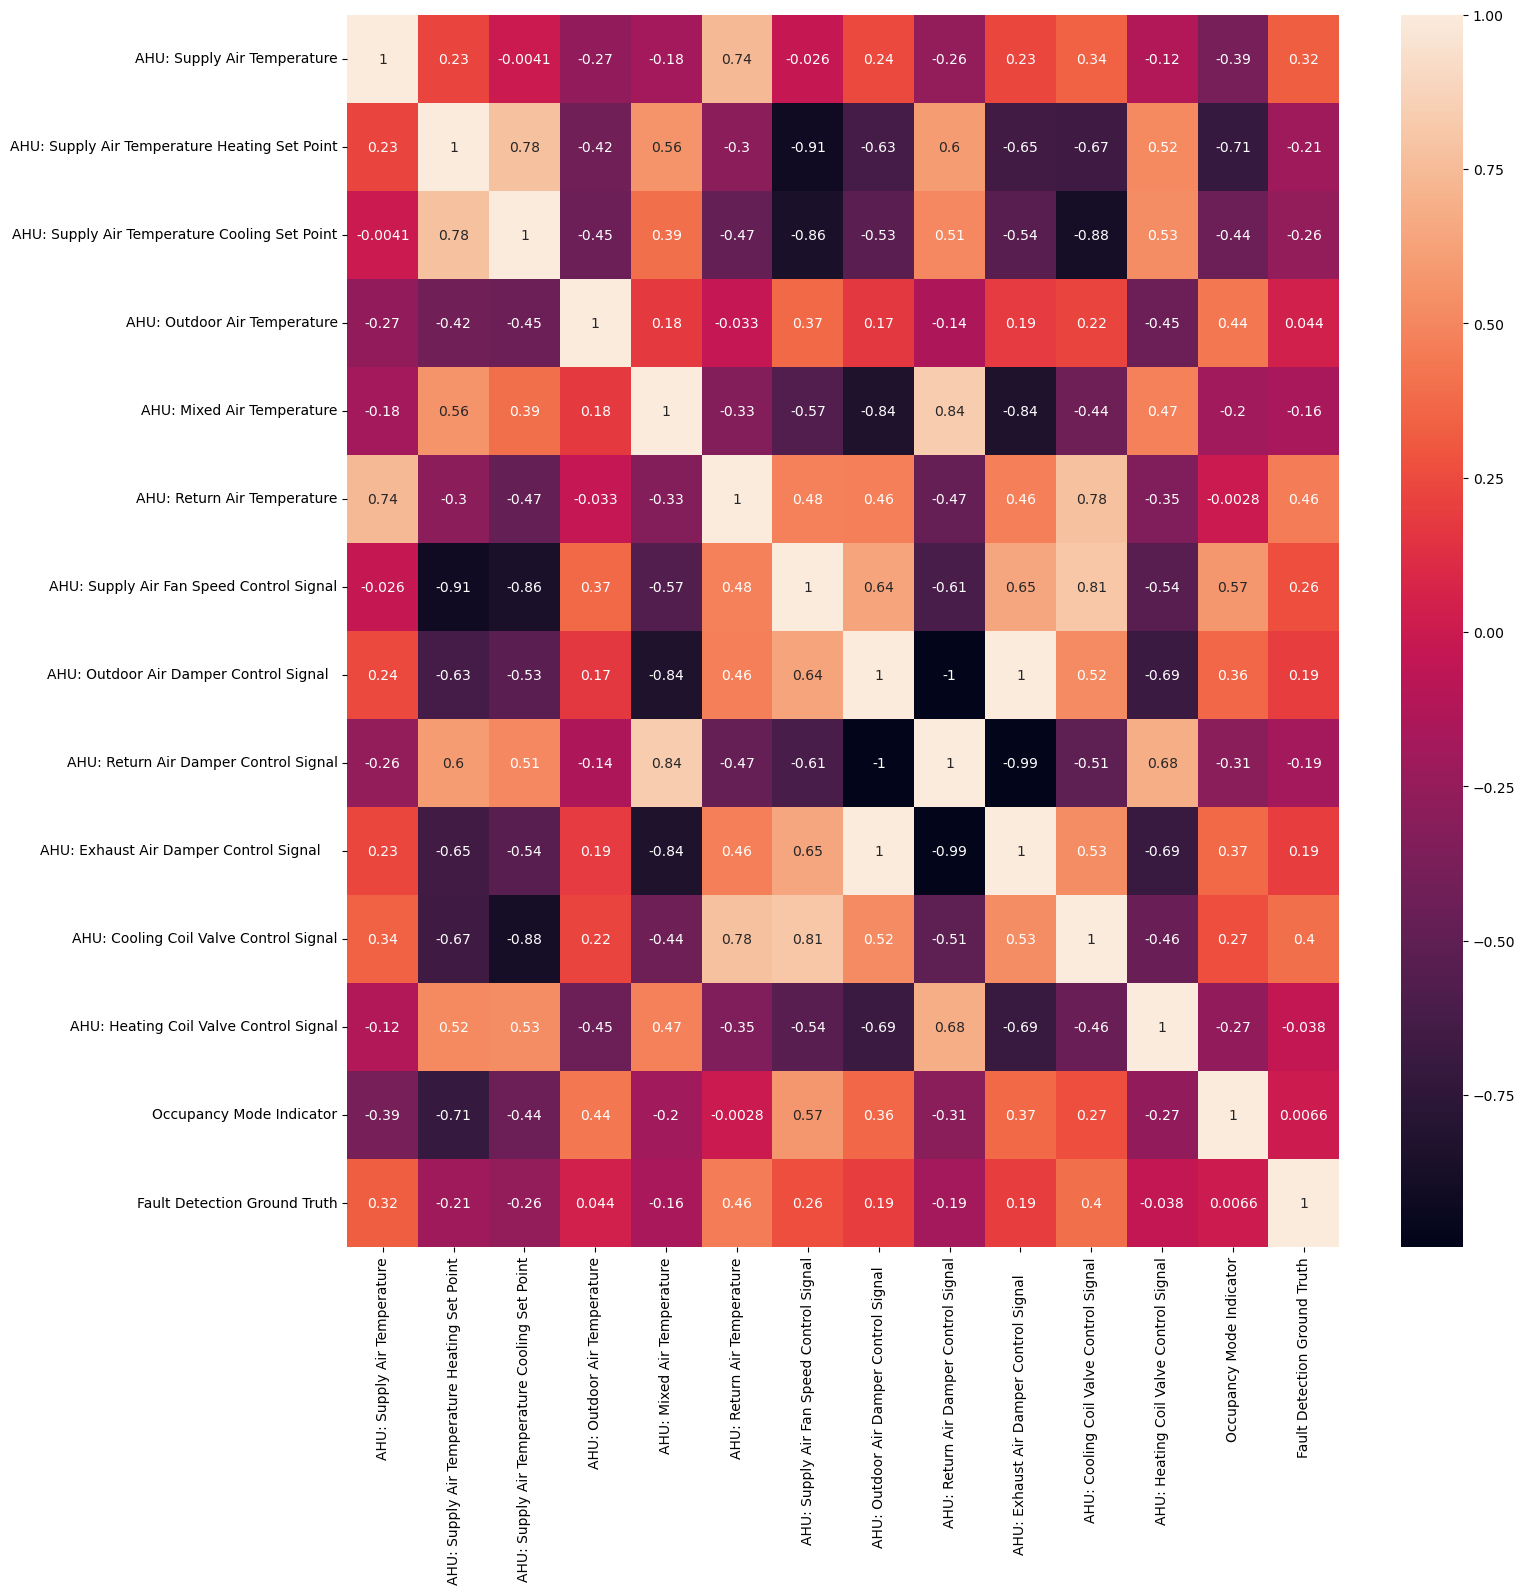

In [101]:
plt.figure(figsize=(16,16))
sns.heatmap(data_vav.corr(), annot=True)

In this dataset there is high correlation among three columns: "AHU: Outdoor Air Damper Control Signal," "AHU: Return Air Damper Control Signal," and "AHU: Exhaust Air Damper Control Signal." This correlation suggests that retaining all three columns might introduce multicollinearity.

In [102]:
data_vav.drop(['AHU: Return Air Damper Control Signal', 'AHU: Exhaust Air Damper Control Signal    '], axis=1, inplace=True)

<AxesSubplot:>

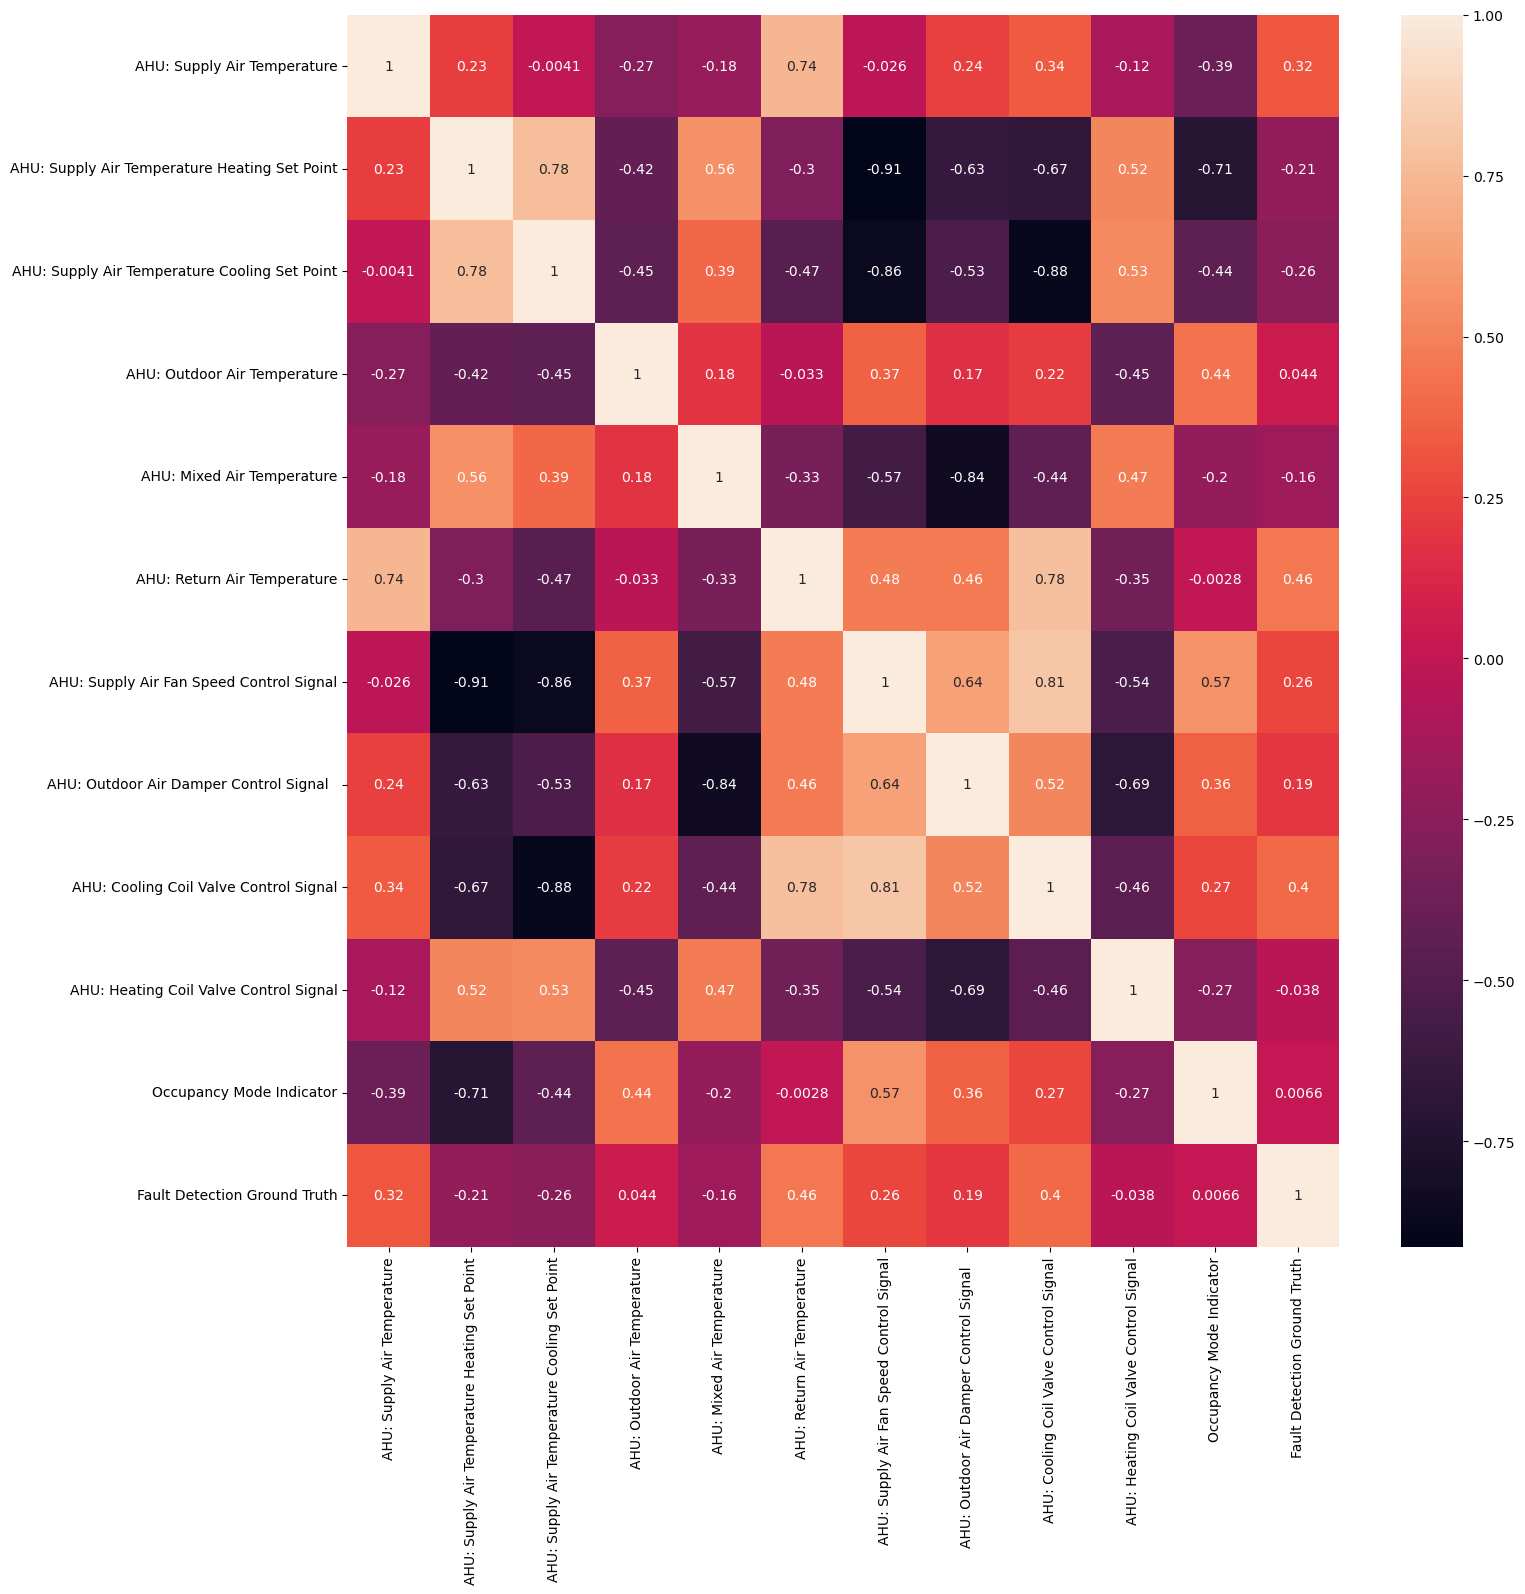

In [103]:
plt.figure(figsize=(16,16))
sns.heatmap(data_vav.corr(), annot=True)

The dataset is now poised for the model building phase. Notably, the "Fault Detection Ground Truth" column displays correlations with certain other columns. However, consistent with the approach taken in previous datasets, this column encompasses a wide array of distinct faults. Therefore, it's recommended to create separate target columns for each specific type of fault, just as was done in previous datasets. This tailored approach ensures that the models can accurately predict the varied fault categories present within the dataset.

In [104]:
# Creating list of dates when faults occured accordin to the description.
OA_fault_dates = [convert_date('9/18/17'), 
                  convert_date('9/19/17')]
heat_vlv_fault_dates = [convert_date('9/14/17'), 
                        convert_date('9/15/17'), 
                        convert_date('9/12/17')]
cool_vlv_fault_dates = [convert_date('9/22/17'), 
                        convert_date('9/11/17')]

In [105]:
# Creating and filling faults column with values according to the dates given earlier.
data_vav['OA_fault'] = 0
data_vav['heat_vlv_fault'] = 0
data_vav['cool_vlv_fault'] = 0
for date in OA_fault_dates:
    data_vav.loc[data_vav['Datetime'].dt.date == date.date(), 'OA_fault'] = 1
for date in heat_vlv_fault_dates:
    data_vav.loc[data_vav['Datetime'].dt.date == date.date(), 'heat_vlv_fault'] = 1
for date in cool_vlv_fault_dates:
    data_vav.loc[data_vav['Datetime'].dt.date == date.date(), 'cool_vlv_fault'] = 1

## Models building

### Feature and target data preparation

In [106]:
X_vav = data_vav.drop(['Datetime','Fault Detection Ground Truth','OA_fault','heat_vlv_fault','cool_vlv_fault'], axis=1)

In [107]:
y_oa = data_vav['OA_fault']
y_heat = data_vav['heat_vlv_fault']
y_cool = data_vav['cool_vlv_fault']

### Train test split

In [108]:
X_train_oa_vav, X_test_oa_vav, y_train_oa_vav, y_test_oa_vav = train_test_split(X_vav, y_oa, test_size=0.1, shuffle=True)
X_train_heat_vav, X_test_heat_vav, y_train_heat_vav, y_test_heat_vav = train_test_split(X_vav, y_heat, test_size=0.1, shuffle=True)
X_train_cool_vav, X_test_cool_vav, y_train_cool_vav, y_test_cool_vav = train_test_split(X_vav, y_cool, test_size=0.1, shuffle=True)

### Classification model training

In [109]:
models_oa_vav, Acc_oa_vav = train_evaluate_classification_models(X_train_oa_vav, X_test_oa_vav, y_train_oa_vav, y_test_oa_vav, classifiers)
models_heat_vav, Acc_heat_vav = train_evaluate_classification_models(X_train_heat_vav, X_test_heat_vav, y_train_heat_vav, y_test_heat_vav, classifiers)
models_cool_vav, Acc_cool_vav = train_evaluate_classification_models(X_train_cool_vav, X_test_cool_vav, y_train_cool_vav, y_test_cool_vav, classifiers)

Learning rate set to 0.031523
0:	learn: 0.6447261	total: 11.1ms	remaining: 11.1s
1:	learn: 0.5988417	total: 19.9ms	remaining: 9.91s
2:	learn: 0.5605748	total: 32.9ms	remaining: 10.9s
3:	learn: 0.5275180	total: 41.7ms	remaining: 10.4s
4:	learn: 0.4966684	total: 49.6ms	remaining: 9.87s
5:	learn: 0.4678100	total: 57.5ms	remaining: 9.52s
6:	learn: 0.4414623	total: 69ms	remaining: 9.79s
7:	learn: 0.4227242	total: 78.7ms	remaining: 9.76s
8:	learn: 0.4051214	total: 88.5ms	remaining: 9.74s
9:	learn: 0.3919703	total: 100ms	remaining: 9.9s
10:	learn: 0.3800876	total: 111ms	remaining: 9.95s
11:	learn: 0.3682266	total: 121ms	remaining: 9.97s
12:	learn: 0.3557171	total: 131ms	remaining: 9.94s
13:	learn: 0.3461592	total: 139ms	remaining: 9.77s
14:	learn: 0.3353737	total: 146ms	remaining: 9.61s
15:	learn: 0.3269988	total: 154ms	remaining: 9.48s
16:	learn: 0.3187511	total: 165ms	remaining: 9.52s
17:	learn: 0.3091489	total: 173ms	remaining: 9.44s
18:	learn: 0.3003078	total: 182ms	remaining: 9.4s
19:	le

173:	learn: 0.0746976	total: 1.88s	remaining: 8.95s
174:	learn: 0.0743002	total: 1.9s	remaining: 8.94s
175:	learn: 0.0739435	total: 1.91s	remaining: 8.92s
176:	learn: 0.0735686	total: 1.92s	remaining: 8.91s
177:	learn: 0.0733315	total: 1.92s	remaining: 8.88s
178:	learn: 0.0729993	total: 1.93s	remaining: 8.87s
179:	learn: 0.0726736	total: 1.95s	remaining: 8.86s
180:	learn: 0.0723395	total: 1.95s	remaining: 8.84s
181:	learn: 0.0721272	total: 1.97s	remaining: 8.85s
182:	learn: 0.0717714	total: 1.98s	remaining: 8.85s
183:	learn: 0.0713822	total: 1.99s	remaining: 8.85s
184:	learn: 0.0710793	total: 2.01s	remaining: 8.84s
185:	learn: 0.0706514	total: 2.02s	remaining: 8.83s
186:	learn: 0.0702318	total: 2.03s	remaining: 8.84s
187:	learn: 0.0698928	total: 2.04s	remaining: 8.84s
188:	learn: 0.0695891	total: 2.06s	remaining: 8.82s
189:	learn: 0.0693730	total: 2.07s	remaining: 8.82s
190:	learn: 0.0691488	total: 2.08s	remaining: 8.82s
191:	learn: 0.0689009	total: 2.1s	remaining: 8.83s
192:	learn: 0.

337:	learn: 0.0361505	total: 3.57s	remaining: 7s
338:	learn: 0.0360789	total: 3.58s	remaining: 6.99s
339:	learn: 0.0359147	total: 3.6s	remaining: 6.98s
340:	learn: 0.0357950	total: 3.6s	remaining: 6.96s
341:	learn: 0.0355812	total: 3.62s	remaining: 6.96s
342:	learn: 0.0353928	total: 3.63s	remaining: 6.95s
343:	learn: 0.0353185	total: 3.63s	remaining: 6.93s
344:	learn: 0.0352142	total: 3.64s	remaining: 6.92s
345:	learn: 0.0351230	total: 3.65s	remaining: 6.91s
346:	learn: 0.0350217	total: 3.67s	remaining: 6.9s
347:	learn: 0.0348433	total: 3.68s	remaining: 6.89s
348:	learn: 0.0347108	total: 3.69s	remaining: 6.88s
349:	learn: 0.0345417	total: 3.7s	remaining: 6.87s
350:	learn: 0.0344158	total: 3.71s	remaining: 6.85s
351:	learn: 0.0343160	total: 3.71s	remaining: 6.84s
352:	learn: 0.0342191	total: 3.72s	remaining: 6.83s
353:	learn: 0.0340486	total: 3.73s	remaining: 6.81s
354:	learn: 0.0339753	total: 3.74s	remaining: 6.8s
355:	learn: 0.0338825	total: 3.75s	remaining: 6.79s
356:	learn: 0.033722

505:	learn: 0.0206416	total: 5.22s	remaining: 5.1s
506:	learn: 0.0205949	total: 5.24s	remaining: 5.1s
507:	learn: 0.0205385	total: 5.26s	remaining: 5.09s
508:	learn: 0.0205070	total: 5.28s	remaining: 5.09s
509:	learn: 0.0204575	total: 5.29s	remaining: 5.08s
510:	learn: 0.0204271	total: 5.3s	remaining: 5.07s
511:	learn: 0.0203514	total: 5.31s	remaining: 5.06s
512:	learn: 0.0203037	total: 5.32s	remaining: 5.05s
513:	learn: 0.0202531	total: 5.33s	remaining: 5.04s
514:	learn: 0.0201958	total: 5.34s	remaining: 5.03s
515:	learn: 0.0200776	total: 5.35s	remaining: 5.02s
516:	learn: 0.0200473	total: 5.36s	remaining: 5.01s
517:	learn: 0.0199870	total: 5.37s	remaining: 5s
518:	learn: 0.0199310	total: 5.38s	remaining: 4.99s
519:	learn: 0.0198652	total: 5.39s	remaining: 4.98s
520:	learn: 0.0198086	total: 5.4s	remaining: 4.97s
521:	learn: 0.0197443	total: 5.42s	remaining: 4.96s
522:	learn: 0.0197141	total: 5.44s	remaining: 4.96s
523:	learn: 0.0196612	total: 5.45s	remaining: 4.95s
524:	learn: 0.01959

683:	learn: 0.0132566	total: 7.13s	remaining: 3.29s
684:	learn: 0.0132265	total: 7.14s	remaining: 3.28s
685:	learn: 0.0132142	total: 7.15s	remaining: 3.27s
686:	learn: 0.0131764	total: 7.16s	remaining: 3.26s
687:	learn: 0.0131652	total: 7.17s	remaining: 3.25s
688:	learn: 0.0131522	total: 7.18s	remaining: 3.24s
689:	learn: 0.0131103	total: 7.19s	remaining: 3.23s
690:	learn: 0.0131072	total: 7.2s	remaining: 3.22s
691:	learn: 0.0130741	total: 7.21s	remaining: 3.21s
692:	learn: 0.0130617	total: 7.21s	remaining: 3.19s
693:	learn: 0.0130172	total: 7.22s	remaining: 3.18s
694:	learn: 0.0129836	total: 7.23s	remaining: 3.17s
695:	learn: 0.0129693	total: 7.24s	remaining: 3.16s
696:	learn: 0.0129574	total: 7.25s	remaining: 3.15s
697:	learn: 0.0129393	total: 7.25s	remaining: 3.14s
698:	learn: 0.0129146	total: 7.26s	remaining: 3.13s
699:	learn: 0.0129021	total: 7.27s	remaining: 3.12s
700:	learn: 0.0128528	total: 7.28s	remaining: 3.1s
701:	learn: 0.0128306	total: 7.29s	remaining: 3.09s
702:	learn: 0.

843:	learn: 0.0096985	total: 8.82s	remaining: 1.63s
844:	learn: 0.0096848	total: 8.83s	remaining: 1.62s
845:	learn: 0.0096689	total: 8.84s	remaining: 1.61s
846:	learn: 0.0096613	total: 8.85s	remaining: 1.6s
847:	learn: 0.0096377	total: 8.86s	remaining: 1.59s
848:	learn: 0.0096235	total: 8.87s	remaining: 1.58s
849:	learn: 0.0096039	total: 8.87s	remaining: 1.57s
850:	learn: 0.0095771	total: 8.89s	remaining: 1.55s
851:	learn: 0.0095508	total: 8.89s	remaining: 1.54s
852:	learn: 0.0095336	total: 8.9s	remaining: 1.53s
853:	learn: 0.0095264	total: 8.91s	remaining: 1.52s
854:	learn: 0.0095152	total: 8.92s	remaining: 1.51s
855:	learn: 0.0094995	total: 8.93s	remaining: 1.5s
856:	learn: 0.0094842	total: 8.94s	remaining: 1.49s
857:	learn: 0.0094649	total: 8.95s	remaining: 1.48s
858:	learn: 0.0094394	total: 8.96s	remaining: 1.47s
859:	learn: 0.0094164	total: 8.96s	remaining: 1.46s
860:	learn: 0.0094140	total: 8.97s	remaining: 1.45s
861:	learn: 0.0093981	total: 8.98s	remaining: 1.44s
862:	learn: 0.0

23:	learn: 0.0202487	total: 212ms	remaining: 8.61s
24:	learn: 0.0179761	total: 226ms	remaining: 8.83s
25:	learn: 0.0160010	total: 235ms	remaining: 8.82s
26:	learn: 0.0144437	total: 245ms	remaining: 8.81s
27:	learn: 0.0129010	total: 253ms	remaining: 8.77s
28:	learn: 0.0117625	total: 263ms	remaining: 8.81s
29:	learn: 0.0109075	total: 272ms	remaining: 8.8s
30:	learn: 0.0100259	total: 281ms	remaining: 8.8s
31:	learn: 0.0094225	total: 291ms	remaining: 8.8s
32:	learn: 0.0087230	total: 301ms	remaining: 8.81s
33:	learn: 0.0081744	total: 312ms	remaining: 8.87s
34:	learn: 0.0077415	total: 325ms	remaining: 8.95s
35:	learn: 0.0071506	total: 335ms	remaining: 8.97s
36:	learn: 0.0066842	total: 347ms	remaining: 9.02s
37:	learn: 0.0062781	total: 359ms	remaining: 9.09s
38:	learn: 0.0059320	total: 367ms	remaining: 9.05s
39:	learn: 0.0055092	total: 377ms	remaining: 9.05s
40:	learn: 0.0051994	total: 389ms	remaining: 9.11s
41:	learn: 0.0049345	total: 398ms	remaining: 9.09s
42:	learn: 0.0047058	total: 409ms	

207:	learn: 0.0004513	total: 2.11s	remaining: 8.05s
208:	learn: 0.0004432	total: 2.12s	remaining: 8.04s
209:	learn: 0.0004432	total: 2.13s	remaining: 8.03s
210:	learn: 0.0004432	total: 2.14s	remaining: 8.01s
211:	learn: 0.0004432	total: 2.15s	remaining: 7.98s
212:	learn: 0.0004432	total: 2.15s	remaining: 7.96s
213:	learn: 0.0004432	total: 2.16s	remaining: 7.94s
214:	learn: 0.0004385	total: 2.17s	remaining: 7.92s
215:	learn: 0.0004385	total: 2.17s	remaining: 7.9s
216:	learn: 0.0004386	total: 2.18s	remaining: 7.87s
217:	learn: 0.0004363	total: 2.19s	remaining: 7.85s
218:	learn: 0.0004363	total: 2.2s	remaining: 7.83s
219:	learn: 0.0004363	total: 2.2s	remaining: 7.81s
220:	learn: 0.0004363	total: 2.21s	remaining: 7.79s
221:	learn: 0.0004363	total: 2.22s	remaining: 7.77s
222:	learn: 0.0004363	total: 2.22s	remaining: 7.75s
223:	learn: 0.0004362	total: 2.23s	remaining: 7.72s
224:	learn: 0.0004362	total: 2.24s	remaining: 7.7s
225:	learn: 0.0004362	total: 2.24s	remaining: 7.68s
226:	learn: 0.00

379:	learn: 0.0004029	total: 3.35s	remaining: 5.46s
380:	learn: 0.0004029	total: 3.35s	remaining: 5.45s
381:	learn: 0.0004029	total: 3.36s	remaining: 5.44s
382:	learn: 0.0004029	total: 3.37s	remaining: 5.43s
383:	learn: 0.0004029	total: 3.38s	remaining: 5.42s
384:	learn: 0.0004029	total: 3.39s	remaining: 5.41s
385:	learn: 0.0004029	total: 3.39s	remaining: 5.4s
386:	learn: 0.0004029	total: 3.4s	remaining: 5.39s
387:	learn: 0.0004029	total: 3.41s	remaining: 5.38s
388:	learn: 0.0004029	total: 3.42s	remaining: 5.37s
389:	learn: 0.0004029	total: 3.43s	remaining: 5.36s
390:	learn: 0.0004029	total: 3.44s	remaining: 5.35s
391:	learn: 0.0004029	total: 3.45s	remaining: 5.34s
392:	learn: 0.0004029	total: 3.45s	remaining: 5.33s
393:	learn: 0.0004029	total: 3.46s	remaining: 5.32s
394:	learn: 0.0004029	total: 3.46s	remaining: 5.31s
395:	learn: 0.0004029	total: 3.47s	remaining: 5.3s
396:	learn: 0.0004029	total: 3.48s	remaining: 5.29s
397:	learn: 0.0004029	total: 3.48s	remaining: 5.27s
398:	learn: 0.0

551:	learn: 0.0004026	total: 4.58s	remaining: 3.72s
552:	learn: 0.0004026	total: 4.59s	remaining: 3.71s
553:	learn: 0.0004026	total: 4.6s	remaining: 3.71s
554:	learn: 0.0004026	total: 4.61s	remaining: 3.7s
555:	learn: 0.0004026	total: 4.62s	remaining: 3.69s
556:	learn: 0.0004026	total: 4.62s	remaining: 3.68s
557:	learn: 0.0004026	total: 4.63s	remaining: 3.67s
558:	learn: 0.0004026	total: 4.64s	remaining: 3.66s
559:	learn: 0.0004026	total: 4.64s	remaining: 3.65s
560:	learn: 0.0004026	total: 4.65s	remaining: 3.64s
561:	learn: 0.0004025	total: 4.66s	remaining: 3.63s
562:	learn: 0.0004026	total: 4.66s	remaining: 3.62s
563:	learn: 0.0004025	total: 4.67s	remaining: 3.61s
564:	learn: 0.0004025	total: 4.68s	remaining: 3.6s
565:	learn: 0.0004025	total: 4.68s	remaining: 3.59s
566:	learn: 0.0004026	total: 4.69s	remaining: 3.58s
567:	learn: 0.0004025	total: 4.7s	remaining: 3.57s
568:	learn: 0.0004026	total: 4.71s	remaining: 3.56s
569:	learn: 0.0004025	total: 4.71s	remaining: 3.56s
570:	learn: 0.00

727:	learn: 0.0004023	total: 5.83s	remaining: 2.18s
728:	learn: 0.0004023	total: 5.84s	remaining: 2.17s
729:	learn: 0.0004023	total: 5.85s	remaining: 2.16s
730:	learn: 0.0004023	total: 5.85s	remaining: 2.15s
731:	learn: 0.0004023	total: 5.86s	remaining: 2.15s
732:	learn: 0.0004023	total: 5.87s	remaining: 2.14s
733:	learn: 0.0004023	total: 5.87s	remaining: 2.13s
734:	learn: 0.0004023	total: 5.88s	remaining: 2.12s
735:	learn: 0.0004023	total: 5.89s	remaining: 2.11s
736:	learn: 0.0004023	total: 5.89s	remaining: 2.1s
737:	learn: 0.0004023	total: 5.9s	remaining: 2.09s
738:	learn: 0.0004023	total: 5.91s	remaining: 2.08s
739:	learn: 0.0004023	total: 5.91s	remaining: 2.08s
740:	learn: 0.0004023	total: 5.92s	remaining: 2.07s
741:	learn: 0.0004022	total: 5.92s	remaining: 2.06s
742:	learn: 0.0004023	total: 5.93s	remaining: 2.05s
743:	learn: 0.0004023	total: 5.94s	remaining: 2.04s
744:	learn: 0.0004023	total: 5.95s	remaining: 2.04s
745:	learn: 0.0004023	total: 5.95s	remaining: 2.03s
746:	learn: 0.

902:	learn: 0.0004020	total: 7.04s	remaining: 757ms
903:	learn: 0.0004020	total: 7.05s	remaining: 749ms
904:	learn: 0.0004020	total: 7.06s	remaining: 741ms
905:	learn: 0.0004020	total: 7.07s	remaining: 733ms
906:	learn: 0.0004020	total: 7.07s	remaining: 725ms
907:	learn: 0.0004020	total: 7.08s	remaining: 717ms
908:	learn: 0.0004019	total: 7.09s	remaining: 710ms
909:	learn: 0.0004019	total: 7.09s	remaining: 702ms
910:	learn: 0.0004019	total: 7.1s	remaining: 694ms
911:	learn: 0.0004019	total: 7.11s	remaining: 686ms
912:	learn: 0.0004019	total: 7.11s	remaining: 678ms
913:	learn: 0.0004019	total: 7.12s	remaining: 670ms
914:	learn: 0.0004019	total: 7.13s	remaining: 663ms
915:	learn: 0.0004019	total: 7.14s	remaining: 655ms
916:	learn: 0.0004019	total: 7.14s	remaining: 647ms
917:	learn: 0.0004019	total: 7.15s	remaining: 639ms
918:	learn: 0.0004019	total: 7.16s	remaining: 631ms
919:	learn: 0.0004019	total: 7.17s	remaining: 623ms
920:	learn: 0.0004019	total: 7.17s	remaining: 615ms
921:	learn: 0

69:	learn: 0.0483507	total: 831ms	remaining: 11s
70:	learn: 0.0477464	total: 847ms	remaining: 11.1s
71:	learn: 0.0469655	total: 857ms	remaining: 11.1s
72:	learn: 0.0461238	total: 865ms	remaining: 11s
73:	learn: 0.0450435	total: 875ms	remaining: 10.9s
74:	learn: 0.0442946	total: 883ms	remaining: 10.9s
75:	learn: 0.0435981	total: 893ms	remaining: 10.9s
76:	learn: 0.0430469	total: 901ms	remaining: 10.8s
77:	learn: 0.0419724	total: 909ms	remaining: 10.7s
78:	learn: 0.0410425	total: 917ms	remaining: 10.7s
79:	learn: 0.0406759	total: 930ms	remaining: 10.7s
80:	learn: 0.0400511	total: 940ms	remaining: 10.7s
81:	learn: 0.0398120	total: 950ms	remaining: 10.6s
82:	learn: 0.0390981	total: 963ms	remaining: 10.6s
83:	learn: 0.0385387	total: 982ms	remaining: 10.7s
84:	learn: 0.0380595	total: 1s	remaining: 10.8s
85:	learn: 0.0374838	total: 1.02s	remaining: 10.8s
86:	learn: 0.0371486	total: 1.03s	remaining: 10.8s
87:	learn: 0.0365400	total: 1.05s	remaining: 10.9s
88:	learn: 0.0356594	total: 1.07s	rema

228:	learn: 0.0102926	total: 2.94s	remaining: 9.88s
229:	learn: 0.0102463	total: 2.95s	remaining: 9.88s
230:	learn: 0.0101947	total: 2.96s	remaining: 9.86s
231:	learn: 0.0101545	total: 2.97s	remaining: 9.84s
232:	learn: 0.0101128	total: 2.98s	remaining: 9.81s
233:	learn: 0.0100339	total: 2.99s	remaining: 9.78s
234:	learn: 0.0099391	total: 3s	remaining: 9.75s
235:	learn: 0.0098710	total: 3s	remaining: 9.73s
236:	learn: 0.0098336	total: 3.01s	remaining: 9.7s
237:	learn: 0.0097919	total: 3.02s	remaining: 9.67s
238:	learn: 0.0096955	total: 3.03s	remaining: 9.65s
239:	learn: 0.0096633	total: 3.04s	remaining: 9.62s
240:	learn: 0.0096126	total: 3.05s	remaining: 9.6s
241:	learn: 0.0095554	total: 3.05s	remaining: 9.57s
242:	learn: 0.0094477	total: 3.06s	remaining: 9.55s
243:	learn: 0.0094112	total: 3.07s	remaining: 9.52s
244:	learn: 0.0093568	total: 3.08s	remaining: 9.49s
245:	learn: 0.0093193	total: 3.09s	remaining: 9.47s
246:	learn: 0.0092695	total: 3.1s	remaining: 9.45s
247:	learn: 0.0092501

406:	learn: 0.0043672	total: 4.81s	remaining: 7.01s
407:	learn: 0.0043511	total: 4.83s	remaining: 7s
408:	learn: 0.0043229	total: 4.84s	remaining: 6.99s
409:	learn: 0.0043191	total: 4.85s	remaining: 6.98s
410:	learn: 0.0043046	total: 4.86s	remaining: 6.96s
411:	learn: 0.0042900	total: 4.87s	remaining: 6.95s
412:	learn: 0.0042685	total: 4.88s	remaining: 6.94s
413:	learn: 0.0042598	total: 4.89s	remaining: 6.93s
414:	learn: 0.0042497	total: 4.91s	remaining: 6.92s
415:	learn: 0.0042343	total: 4.92s	remaining: 6.9s
416:	learn: 0.0042242	total: 4.93s	remaining: 6.89s
417:	learn: 0.0042152	total: 4.94s	remaining: 6.88s
418:	learn: 0.0041881	total: 4.95s	remaining: 6.86s
419:	learn: 0.0041707	total: 4.96s	remaining: 6.84s
420:	learn: 0.0041386	total: 4.96s	remaining: 6.83s
421:	learn: 0.0041239	total: 4.97s	remaining: 6.81s
422:	learn: 0.0041015	total: 4.99s	remaining: 6.8s
423:	learn: 0.0040941	total: 4.99s	remaining: 6.78s
424:	learn: 0.0040617	total: 5s	remaining: 6.77s
425:	learn: 0.004048

569:	learn: 0.0024971	total: 6.49s	remaining: 4.9s
570:	learn: 0.0024840	total: 6.5s	remaining: 4.88s
571:	learn: 0.0024700	total: 6.51s	remaining: 4.87s
572:	learn: 0.0024675	total: 6.52s	remaining: 4.86s
573:	learn: 0.0024618	total: 6.53s	remaining: 4.85s
574:	learn: 0.0024462	total: 6.54s	remaining: 4.83s
575:	learn: 0.0024350	total: 6.55s	remaining: 4.82s
576:	learn: 0.0024330	total: 6.56s	remaining: 4.81s
577:	learn: 0.0024208	total: 6.56s	remaining: 4.79s
578:	learn: 0.0024091	total: 6.57s	remaining: 4.78s
579:	learn: 0.0024080	total: 6.58s	remaining: 4.76s
580:	learn: 0.0024031	total: 6.59s	remaining: 4.75s
581:	learn: 0.0024001	total: 6.6s	remaining: 4.74s
582:	learn: 0.0023935	total: 6.61s	remaining: 4.73s
583:	learn: 0.0023817	total: 6.62s	remaining: 4.71s
584:	learn: 0.0023733	total: 6.63s	remaining: 4.7s
585:	learn: 0.0023695	total: 6.63s	remaining: 4.69s
586:	learn: 0.0023676	total: 6.64s	remaining: 4.67s
587:	learn: 0.0023558	total: 6.66s	remaining: 4.66s
588:	learn: 0.00

730:	learn: 0.0020766	total: 7.74s	remaining: 2.85s
731:	learn: 0.0020766	total: 7.75s	remaining: 2.84s
732:	learn: 0.0020766	total: 7.76s	remaining: 2.83s
733:	learn: 0.0020766	total: 7.76s	remaining: 2.81s
734:	learn: 0.0020766	total: 7.77s	remaining: 2.8s
735:	learn: 0.0020766	total: 7.77s	remaining: 2.79s
736:	learn: 0.0020766	total: 7.78s	remaining: 2.78s
737:	learn: 0.0020766	total: 7.79s	remaining: 2.76s
738:	learn: 0.0020766	total: 7.79s	remaining: 2.75s
739:	learn: 0.0020766	total: 7.8s	remaining: 2.74s
740:	learn: 0.0020766	total: 7.81s	remaining: 2.73s
741:	learn: 0.0020766	total: 7.82s	remaining: 2.72s
742:	learn: 0.0020766	total: 7.82s	remaining: 2.71s
743:	learn: 0.0020766	total: 7.83s	remaining: 2.69s
744:	learn: 0.0020766	total: 7.83s	remaining: 2.68s
745:	learn: 0.0020766	total: 7.84s	remaining: 2.67s
746:	learn: 0.0020766	total: 7.85s	remaining: 2.66s
747:	learn: 0.0020766	total: 7.86s	remaining: 2.65s
748:	learn: 0.0020766	total: 7.86s	remaining: 2.63s
749:	learn: 0.

907:	learn: 0.0020766	total: 9s	remaining: 912ms
908:	learn: 0.0020766	total: 9.01s	remaining: 902ms
909:	learn: 0.0020766	total: 9.02s	remaining: 892ms
910:	learn: 0.0020766	total: 9.03s	remaining: 882ms
911:	learn: 0.0020766	total: 9.04s	remaining: 873ms
912:	learn: 0.0020766	total: 9.05s	remaining: 863ms
913:	learn: 0.0020766	total: 9.07s	remaining: 853ms
914:	learn: 0.0020766	total: 9.08s	remaining: 843ms
915:	learn: 0.0020766	total: 9.09s	remaining: 833ms
916:	learn: 0.0020766	total: 9.1s	remaining: 824ms
917:	learn: 0.0020766	total: 9.11s	remaining: 813ms
918:	learn: 0.0020766	total: 9.12s	remaining: 803ms
919:	learn: 0.0020766	total: 9.13s	remaining: 794ms
920:	learn: 0.0020766	total: 9.13s	remaining: 784ms
921:	learn: 0.0020766	total: 9.15s	remaining: 774ms
922:	learn: 0.0020766	total: 9.16s	remaining: 764ms
923:	learn: 0.0020766	total: 9.17s	remaining: 754ms
924:	learn: 0.0020766	total: 9.18s	remaining: 744ms
925:	learn: 0.0020766	total: 9.18s	remaining: 734ms
926:	learn: 0.00

## Models evaluation

In [110]:
print(Acc_oa_vav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.993806       0.988852         0.983436   
1               MLPClassifier        0.873934       0.881967         0.728473   
2          AdaBoostClassifier        0.932668       0.937705         0.882380   
3  GradientBoostingClassifier        0.968374       0.957377         0.963138   
4          CatBoostClassifier        0.999927       0.994098         1.000000   
5               XGBClassifier        1.000000       0.992787         1.000000   
6           BaggingClassifier        0.999781       0.992131         1.000000   
7      RandomForestClassifier        1.000000       0.992787         1.000000   
8      DecisionTreeClassifier        1.000000       0.990820         1.000000   
9          LogisticRegression        0.800189       0.804590         0.388467   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.971831      0.983815     0.968

In [111]:
print(Acc_heat_vav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.999417            1.0              1.0   
1               MLPClassifier        0.999271            1.0              1.0   
2          AdaBoostClassifier        1.000000            1.0              1.0   
3  GradientBoostingClassifier        1.000000            1.0              1.0   
4          CatBoostClassifier        1.000000            1.0              1.0   
5               XGBClassifier        1.000000            1.0              1.0   
6           BaggingClassifier        1.000000            1.0              1.0   
7      RandomForestClassifier        1.000000            1.0              1.0   
8      DecisionTreeClassifier        1.000000            1.0              1.0   
9          LogisticRegression        0.999417            1.0              1.0   

   test_precision  train_recall  test_recall  train_f1  test_f1  
0             1.0      0.997939          1

In [112]:
print(Acc_cool_vav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.998688       0.994754         0.996577   
1               MLPClassifier        0.961452       0.957377         0.965686   
2          AdaBoostClassifier        0.986373       0.983607         0.975000   
3  GradientBoostingClassifier        0.993660       0.988852         0.992965   
4          CatBoostClassifier        0.999927       0.998689         0.999512   
5               XGBClassifier        1.000000       0.997377         1.000000   
6           BaggingClassifier        0.999781       0.997377         0.999512   
7      RandomForestClassifier        1.000000       0.997377         1.000000   
8      DecisionTreeClassifier        1.000000       0.996721         1.000000   
9          LogisticRegression        0.924215       0.923934         0.950849   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.979339      0.994632     0.987

Most of the models perfored excellent without any tuning and balancing as the models in the previous dataset/

# Feature importances - comparison between systems

In preceding sections, analogous models were developed for systems with subtle differences. This strategic approach enables us to conduct a comparative analysis to vaerify whether noteworthy distinctions exist between these systems. Moreover, this comparison allows us to assess the potential feasibility of employing a single model across different systems, irrespective of the specific system being analyzed. Such insights contribute to understanding the extent of model generalizability and applicability across diverse scenarios.

<BarContainer object of 12 artists>

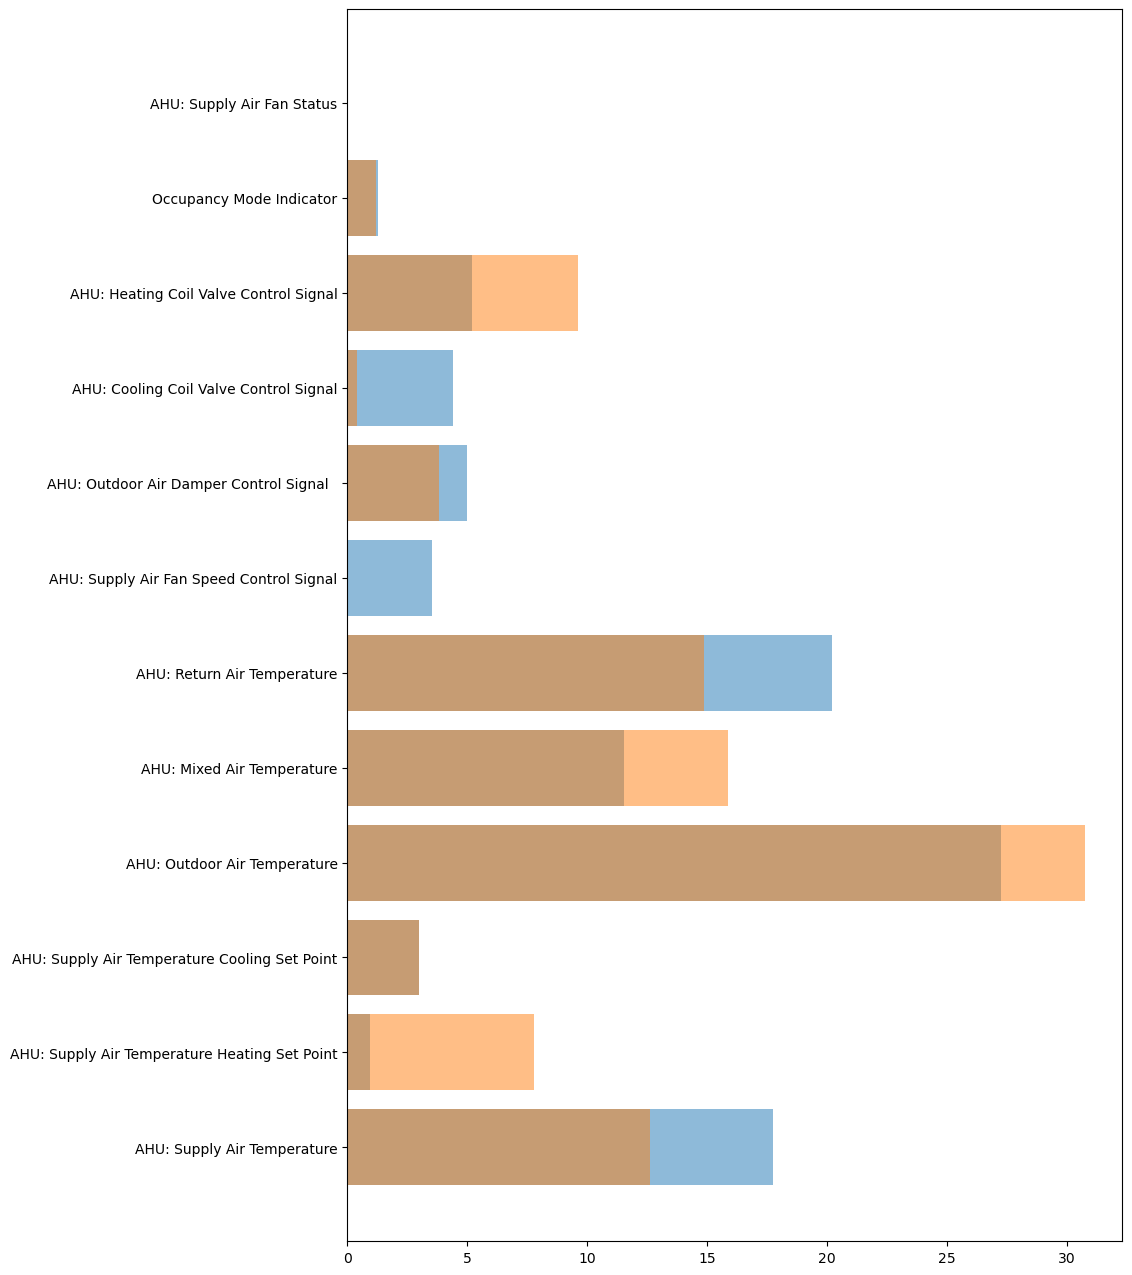

In [119]:
plt.figure(figsize=(10,16))
plt.barh(X_train_oa_vav.columns, models_oa_vav[4].get_feature_importance(), alpha=0.5)
plt.barh(X_train_oa_cav.columns, models_oa_cav[4].get_feature_importance(), alpha=0.5)

<BarContainer object of 12 artists>

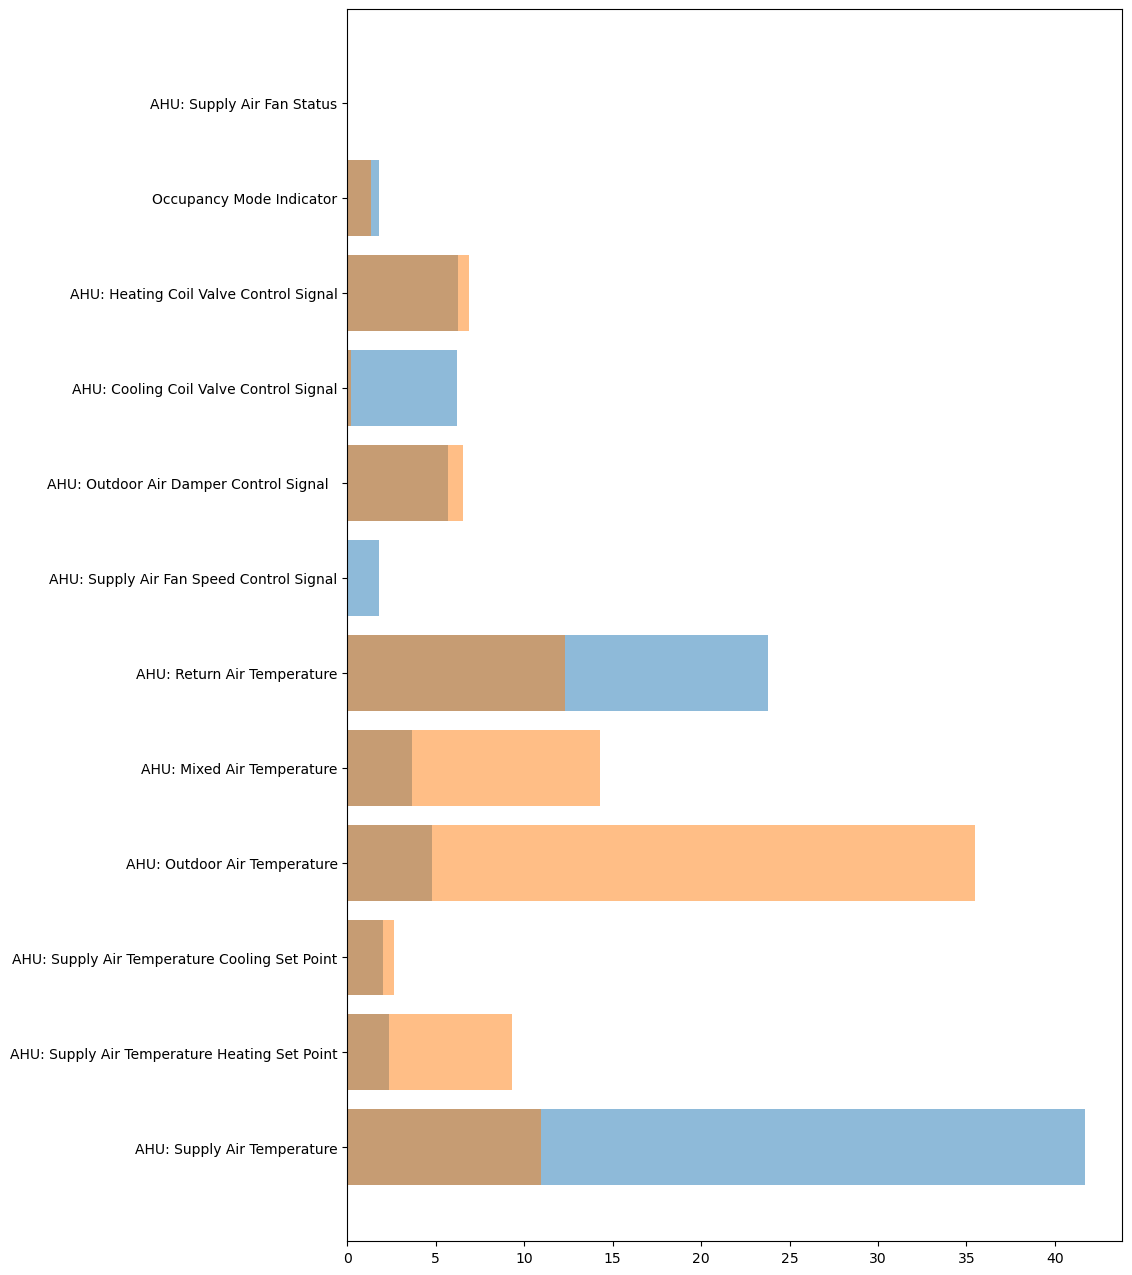

In [120]:
plt.figure(figsize=(10,16))
plt.barh(X_train_heat_vav.columns, models_heat_vav[4].get_feature_importance(), alpha=0.5)
plt.barh(X_train_heat_cav.columns, models_heat_cav[4].get_feature_importance(), alpha=0.5)

<BarContainer object of 12 artists>

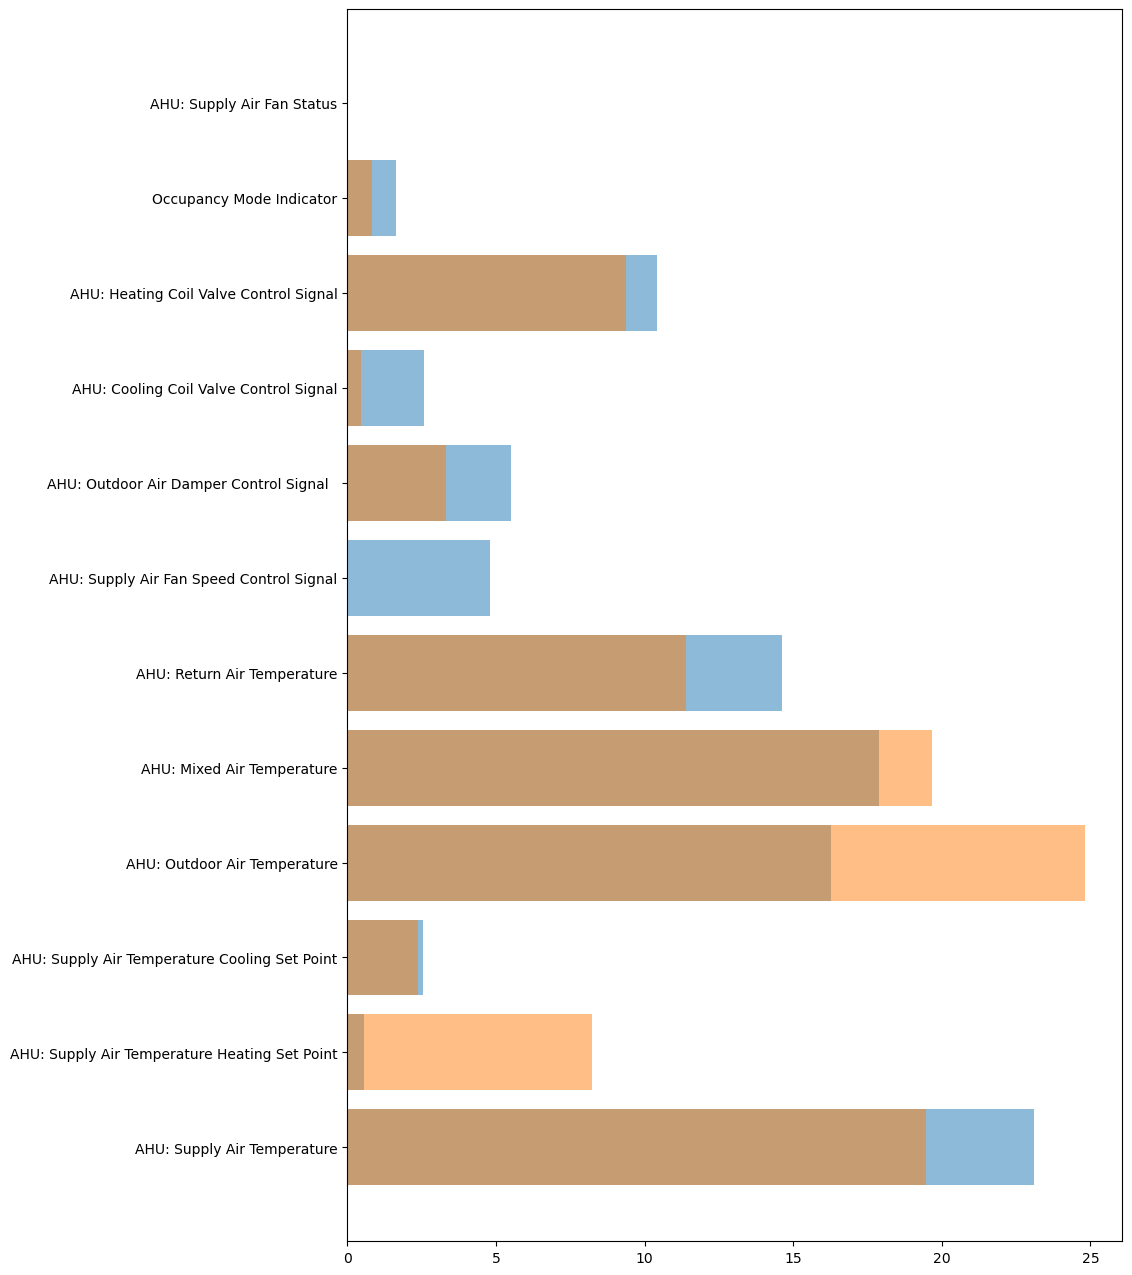

In [121]:
plt.figure(figsize=(10,16))
plt.barh(X_train_cool_vav.columns, models_cool_vav[4].get_feature_importance(), alpha=0.5)
plt.barh(X_train_cool_cav.columns, models_cool_cav[4].get_feature_importance(), alpha=0.5)

The illustrated feature importances provide valuable insights: they highlight the necessity of tailoring models to specific systems rather than relying on broad generalization. These results underscore the limitations of model applicability across different systems. The specificity of features crucial to each system accentuates the importance of system-specific modeling to ensure accurate predictions and reliable performance.

# Final toughts and conclusions

The analyzed datasets present a wealth of invaluable information concerning system behavior during failures. The majority of algorithms showcased remarkable performance in detecting faults, suggesting that the signs of failures are distinct and readily discernible to these algorithms. Upon closer scrutiny of the dataset, it might even be feasible to formulate specific fault detection conditions programmatically.

Nevertheless, leveraging machine learning algorithms offers expediency and simplicity, particularly in cases where specialized industry knowledge may be lacking. These algorithms offer rapid and effective fault detection solutions, circumventing the need for extensive domain expertise.

Developing such algorithms would ideally involve collaboration during the initial stages of building maintenance, ensuring precise fault identification or comprehensive functional tests during system commissioning. It's worth noting that these algorithms are likely to remain effective only within specific types of AHUs, possibly even specific AHU instances. However, integrating these algorithms right from the system's inception could yield substantial advantages throughout its operational lifespan.